In [7]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [8]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [9]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [10]:
qfl_factors = globals()['qfl_{0}'.format('Insider Activity').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [11]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [12]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [13]:
qfl_df = df

In [14]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)"
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,16460641.0,1.959639e+09,18.0,0.10,333352.0,368657.0,333352.0,2968192.0,26876.0,4628476.0,9863781.0,8870957.0,242796.0,249265.0,242796.0,651696.0,-2604.0,-508068.0,-3586075.0,-10727095.0,0.0,0.0,0.0,0.0,3.0,9.0,17.0,41.0,2.0,12.0,14.0,30.0,0.0,0.0,0.0,0.0,17000.0,563814.0,1624454.0,2013178.0,88004.0,2487946.0,5907306.0,7283438.0
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,111922509.0,2.395925e+10,31.0,1.48,117845.0,2193624.0,2176292.0,4336643.0,2172707.0,2113555.0,5416984.0,4092332.0,102040.0,279321.0,353777.0,531733.0,-309678.0,-1107972.0,-1292188.0,-3982342.0,0.0,0.0,0.0,0.0,4.0,12.0,16.0,35.0,0.0,9.0,11.0,24.0,0.0,0.0,0.0,0.0,304500.0,414542.0,475616.0,851844.0,0.0,250821.0,252135.0,664804.0
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,73313761.0,2.322609e+11,27.0,14.64,183066.0,205520.0,201930.0,410385.0,53353551.0,53373608.0,53378792.0,72897051.0,112943.0,114812.0,115165.0,138391.0,-1229423.0,-2631474.0,-2280734.0,-4628228.0,0.0,34.0,79.0,98.0,244.0,244.0,385.0,652.0,10.0,10.0,17.0,41.0,0.0,100.0,200.0,400.0,1016312.0,1016312.0,2030117.0,4072070.0,9317.0,9317.0,18249.0,51274.0
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,25711701.0,7.121370e+09,31.0,1.07,9954513.0,10977599.0,10911501.0,18246901.0,5071190.0,4402321.0,4740228.0,6439837.0,75355.0,8348656.0,8435429.0,8382068.0,-243209.0,-338889.0,-5493937.0,-13663010.0,0.0,0.0,0.0,0.0,299.0,309.0,327.0,369.0,42.0,42.0,82.0,164.0,0.0,0.0,0.0,0.0,715770.0,732714.0,752429.0,919577.0,353401.0,353401.0,673028.0,1372956.0
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,40791948.0,7.182402e+10,18.0,12.23,2293.0,199079.0,467389.0,466184.0,19230424.0,19430808.0,20263513.0,20311047.0,100.0,7367.0,179730.0,195413.0,-9960.0,-4108413.0,-4400632.0,-4417176.0,0.0,0.0,0.0,0.0,1.0,3.0,33.0,123.0,0.0,6.0,14.0,35.0,0.0,0.0,0.0,0.0,20.0,62.0,228.0,58462.0,0.0,9228.0,21130.0,98739.0


In [15]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)"
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,15251896.0,2.835236e+08,13.0,10.55,21870.0,15043933.0,15043933.0,15045433.0,15003563.0,1500.0,1500.0,NaN,10790.0,549570.0,772560.0,1194918.0,-421220.0,-1000.0,-1000.0,NaN,0.0,21.0,32.0,163.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,430300.0,960080.0,1602680.0,0.0,0.0,0.0,762.0,0.0,0.0,0.0,0.0
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,633269008.0,1.393940e+09,16.0,53.70,NaN,3587665.0,3587665.0,3587665.0,NaN,NaN,NaN,0.0,NaN,2789137.0,2789137.0,2789137.0,NaN,NaN,NaN,-5000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,4213869.0,5.062886e+07,19.0,1.93,NaN,3587345.0,3587345.0,4137196.0,NaN,137824.0,137824.0,28424.0,NaN,2190931.0,2190931.0,1401754.0,NaN,-25876.0,-14662625.0,-21666459.0,0.0,10.0,16.0,35.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,7.0,0.0,61550.0,78550.0,197602.0,0.0,0.0,0.0,81826.0,0.0,0.0,0.0,27200.0
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,847248909.0,1.531050e+09,64.0,56.85,NaN,NaN,NaN,400628.0,NaN,1913200.0,1913200.0,1927300.0,NaN,NaN,NaN,73580.0,NaN,-56200.0,-56200.0,-234800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,45374332.0,9.577738e+08,49.0,48.27,NaN,3922710.0,3922710.0,9391308.0,NaN,11136100.0,11136100.0,11342100.0,NaN,12210.0,12210.0,1834497.0,NaN,-11900.0,-11900.0,-206600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)"
count,1600.0,1600.000000,1597.000000,1.598000e+03,1.586000e+03,1.586000e+03,1586.000000,1586.000000,6.520000e+02,1.096000e+03,1.285000e+03,1.505000e+03,6.110000e+02,1.015000e+03,1.200000e+03,1.452000e+03,6.520000e+02,1.096000e+03,1.285000e+03,1.505000e+03,6.110000e+02,1.015000e+03,1.200000e+03,1.452000e+03,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03
mean,890100.0,0.062500,3.118575,3.489420e+04,2.152885e+08,4.127381e+09,27.948928,17.414571,1.530998e+07,3.041645e+07,4.280182e+07,6.841570e+07,1.082401e+07,1.541041e+07,2.398535e+07,2.862978e+07,3.025865e+06,4.053455e+06,7.423357e+06,1.178854e+07,-3.143575e+06,-4.861553e+06,-7.627650e+06,-1.076280e+07,0.409149,1.605464,3.037484,8.095299,3.174079,6.741423,12.592122,23.601652,1.604828,3.466963,6.987294,20.220457,2.907452e+04,3.826238e+05,6.783121e+05,2.323913e+06,1.696239e+05,5.980114e+05,9.382870e+05,1.592738e+06,3.370072e+04,8.323293e+04,2.273094e+05,4.604955e+05
std,0.0,0.177252,7.256757,9.150908e+04,7.661507e+08,1.253464e+10,58.672759,21.288075,9.826654e+07,2.088189e+08,3.233039e+08,4.868577e+08,5.157430e+07,8.741381e+07,2.347638e+08,2.234691e+08,3.347252e+07,3.407504e+07,5.047548e+07,6.278149e+07,2.302314e+07,4.118526e+07,5.216883e+07,5.865032e+07,2.278246,6.665183,12.347037,26.228442,21.678667,31.980920,55.874201,91.349908,5.469223,9.053692,16.527766,35.993011,4.428656e+05,9.145055e+06,1.190825e+07,3.833782e+07,2.445590e+06,1.015441e+07,1.151439e+07,1.360516e+07,2.790564e+05,1.002054e+06,2.515885e+06,2.774874e+06
min,890100.0,0.002419,-31.602722,2.063382e+03,1.000000e+03,1.428981e+05,1.000000,0.000000,8.700000e+01,3.000000e+00,3.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,6.600000e+01,-4.540438e+08,-1.028061e+09,-1.268061e+09,-1.268227e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,890100.0,0.012927,-1.169592,8.494103e+03,2.028809e+06,1.455082e+08,12.000000,0.670000,3.998725e+04,1.077802e+05,1.914180e+05,5.381180e+05,3.168300e+04,4.622900e+04,6.275875e+04,7.000000e+04,2.492000e+03,6.765000e+03,1.995700e+04,9.279500e+04,-2.595020e+05,-6.370260e+05,-1.272162e+06,-3.932998e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [17]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                          0
DATE                                  0
SECURITY_ID                           0
Weight                                0
proper_name                           0
fg_gics_sector                        2
proper                                0
p_total_return                        3
qfl_size_class                        2
qfl_mkt_val_sec                       2
QFL_INSIDER_POS(0)                   14
QFL_INSIDER_MV(0)                    14
QFL_INSIDER_HLDRS(0)                 14
QFL_INSIDER_PCTOUT(0)                14
QFL_INSIDER_BUYER_POS(0,1M)         948
QFL_INSIDER_BUYER_POS(0,3M)         504
QFL_INSIDER_BUYER_POS(0,6M)         315
QFL_INSIDER_BUYER_POS(0,12M)         95
QFL_INSIDER_SELLER_POS(0,1M)        989
QFL_INSIDER_SELLER_POS(0,3M)        585
QFL_INSIDER_SELLER_POS(0,6M)        400
QFL_INSIDER_SELLER_POS(0,12M)       148
QFL_INSIDER_BUYER_POSCHG(0,1M)      948
QFL_INSIDER_BUYER_POSCHG(0,3M)      504
QFL_INSIDER_BUYER_POSCHG(0,6M)      315


In [18]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

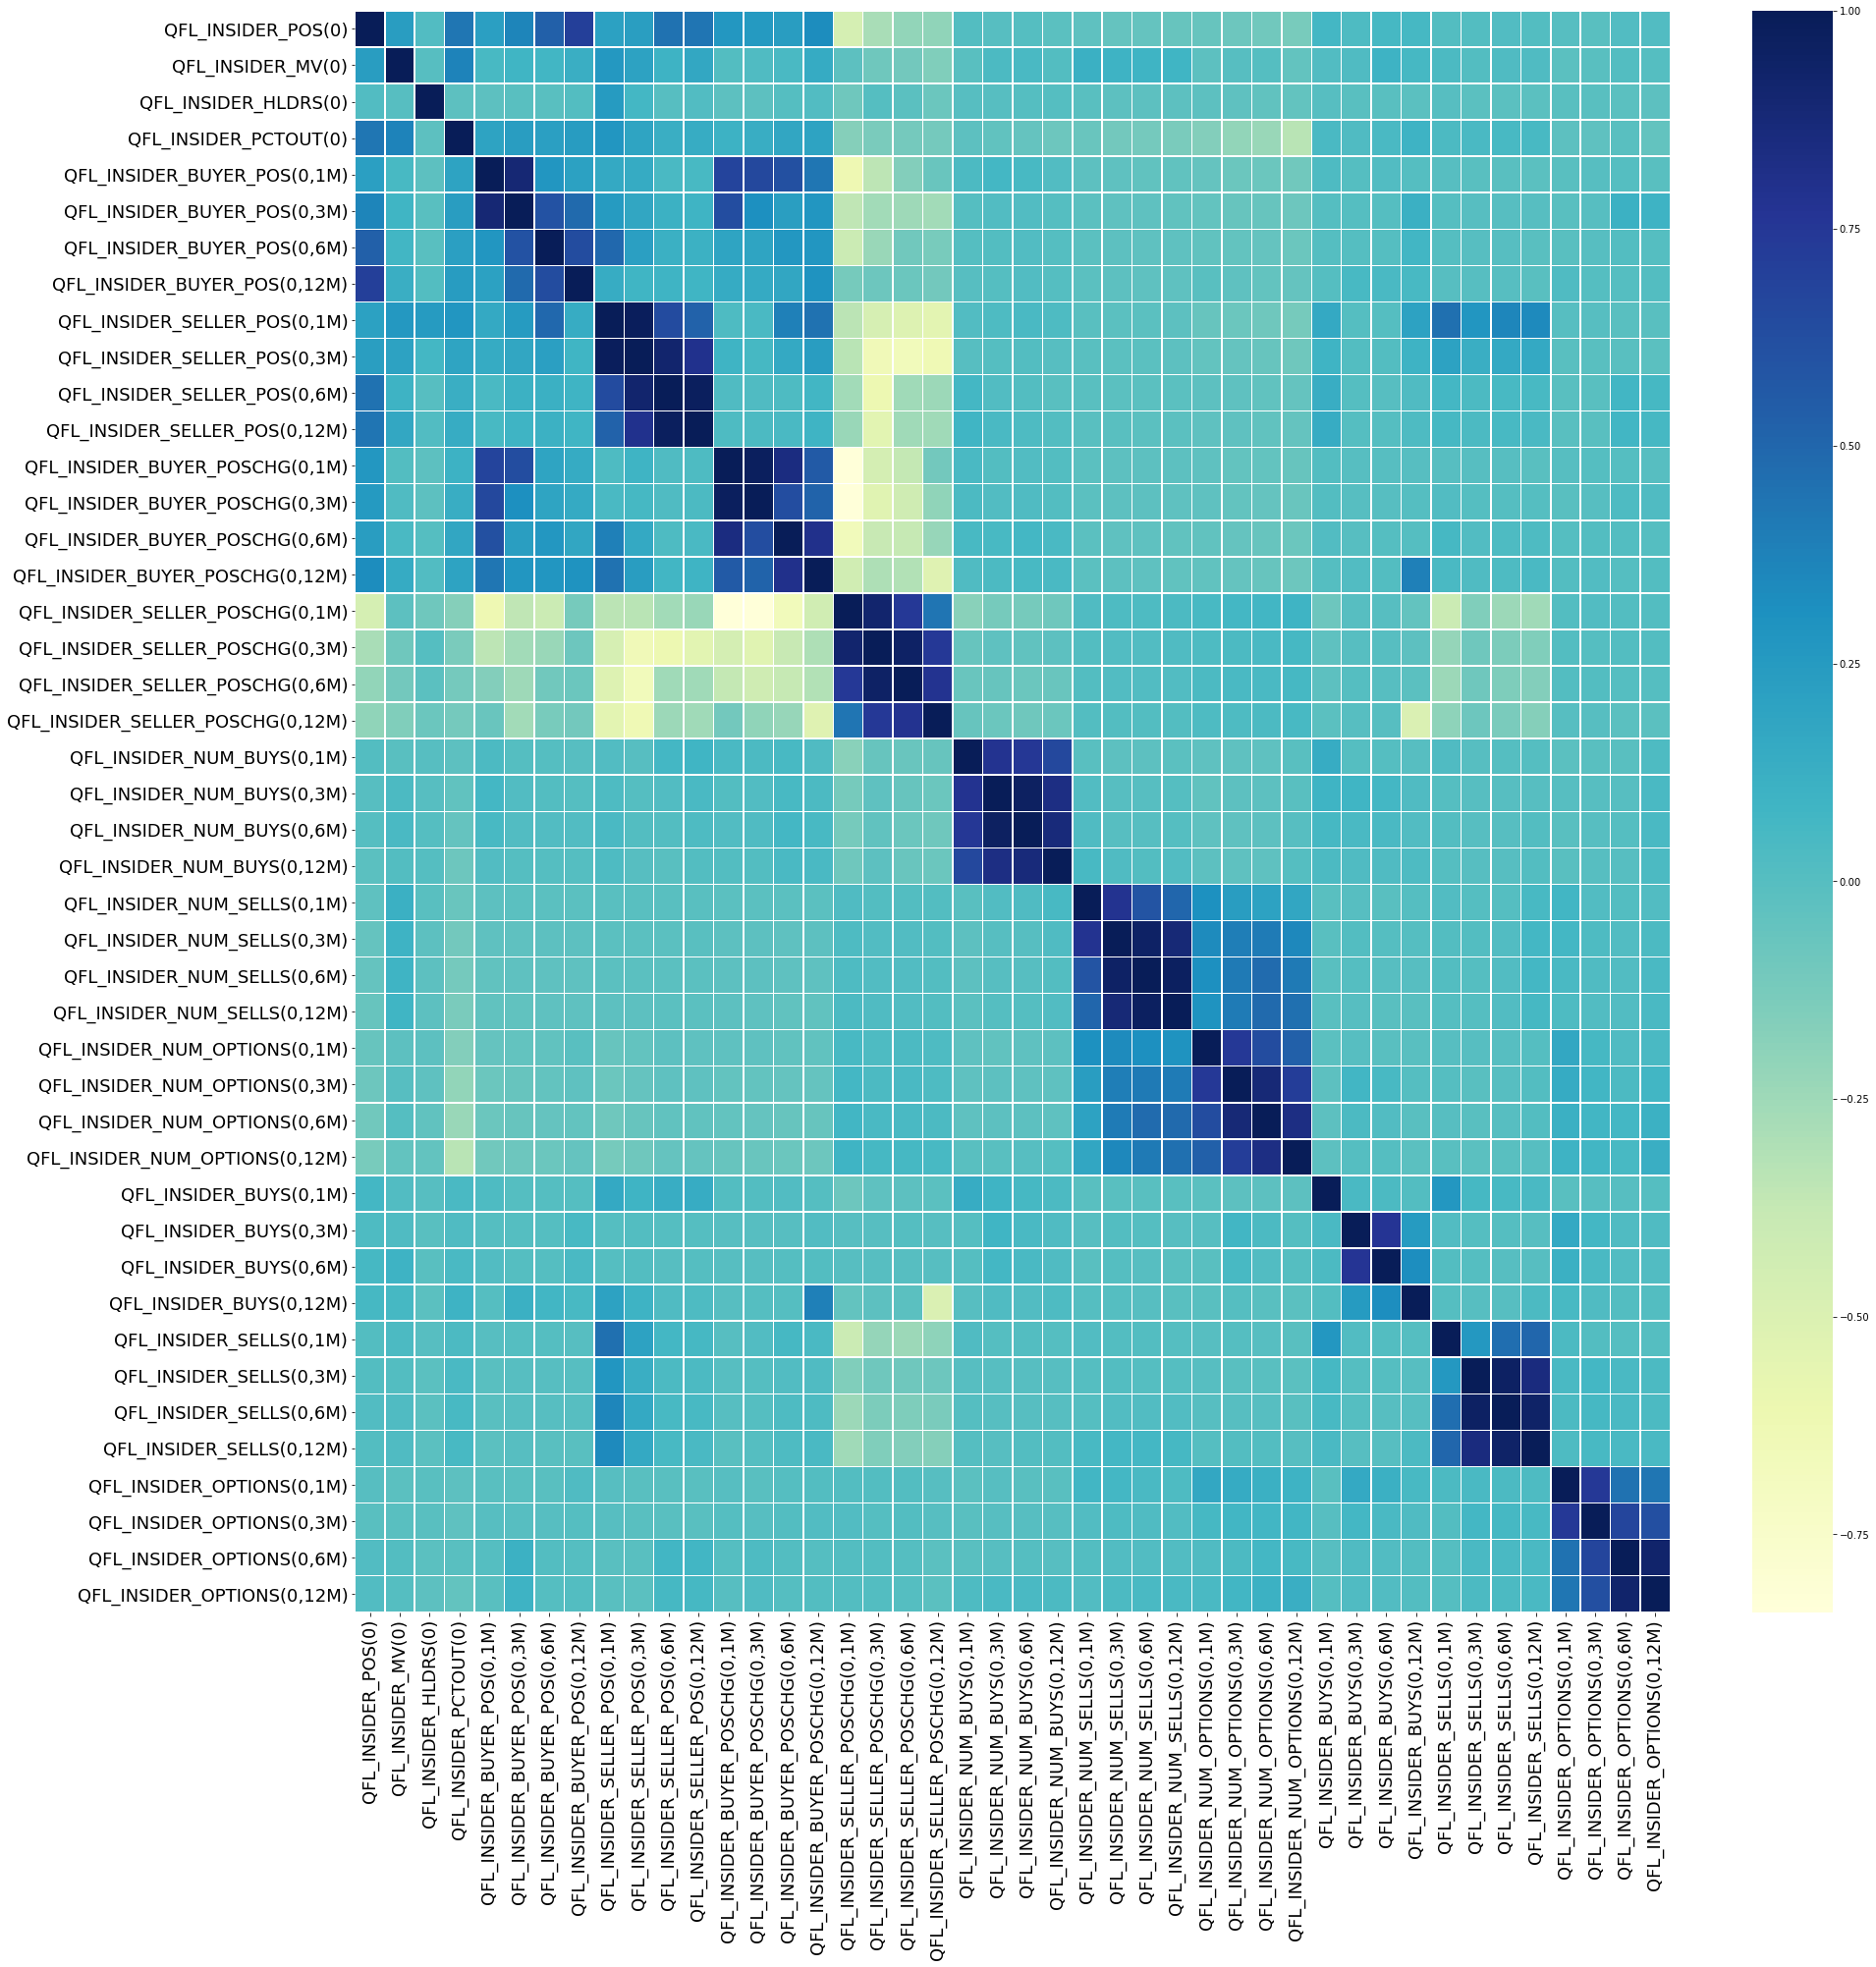

In [56]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

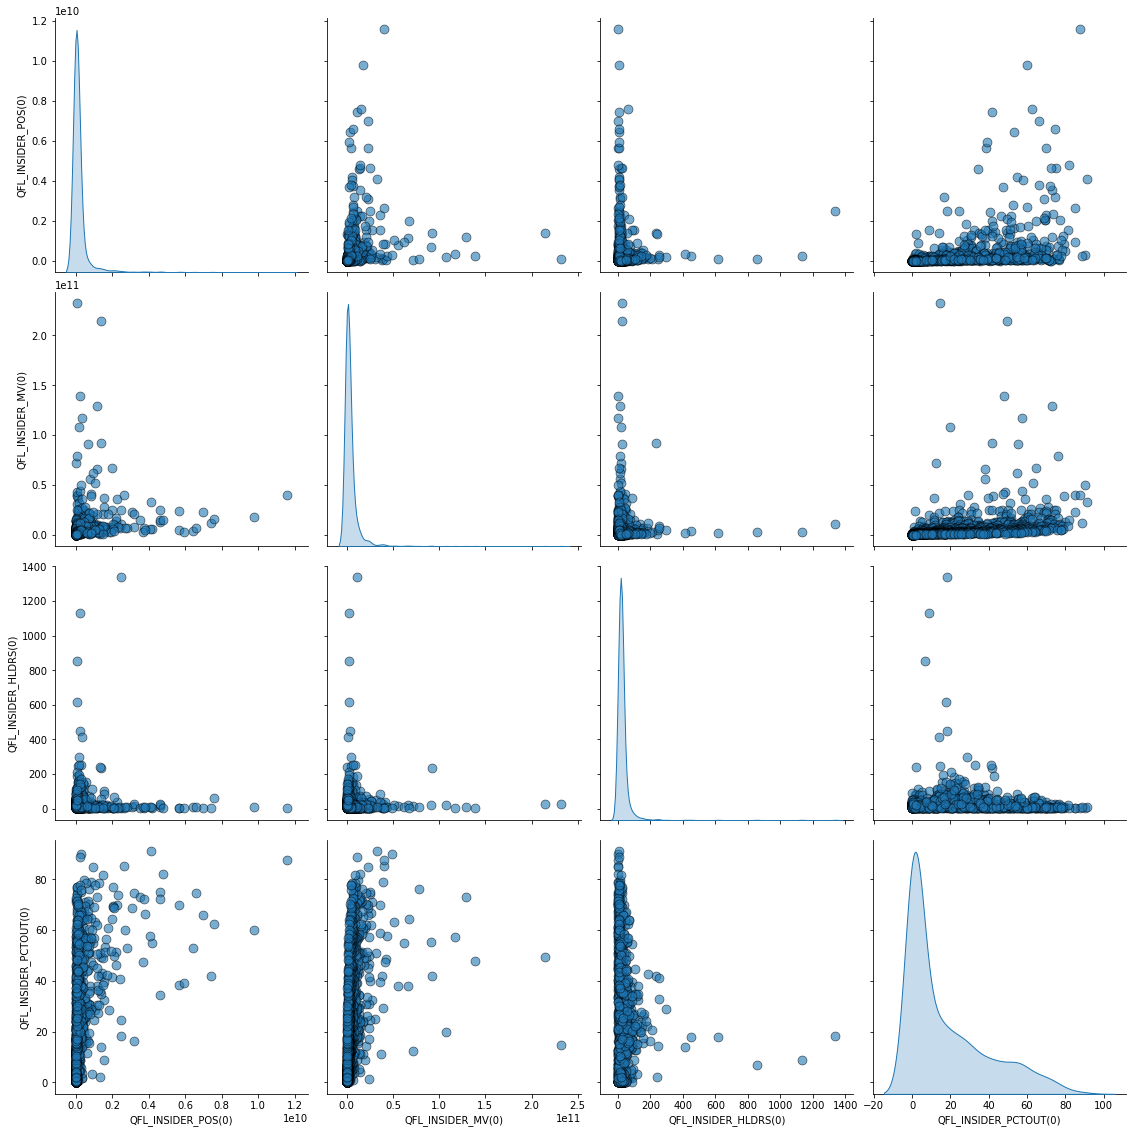

In [20]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [21]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0)
0,16460641.0,1.959639e+09,18.0,0.10
1,111922509.0,2.395925e+10,31.0,1.48
2,73313761.0,2.322609e+11,27.0,14.64
3,25711701.0,7.121370e+09,31.0,1.07
4,40791948.0,7.182402e+10,18.0,12.23
...,...,...,...,...
1595,15251896.0,2.835236e+08,13.0,10.55
1596,633269008.0,1.393940e+09,16.0,53.70
1597,4213869.0,5.062886e+07,19.0,1.93
1598,847248909.0,1.531050e+09,64.0,56.85


In [22]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
QFL_INSIDER_POS(0),1586,"[1000.0, 11573438820.0]",2.15288e+08,5.86987e+17,7.61,74.25
QFL_INSIDER_MV(0),1586,"[142898.06, 232260930000.0]",4.12738e+09,1.57117e+20,10.28,144.7
QFL_INSIDER_HLDRS(0),1586,"[1.0, 1338.0]",27.95,3442.49,14.41,268
QFL_INSIDER_PCTOUT(0),1586,"[0.0, 91.07]",17.41,453.18,1.22,0.46
"QFL_INSIDER_BUYER_POS(0,1M)",652,"[87.0, 1695352306.0]",1.531e+07,9.65631e+15,12.21,174.98
"QFL_INSIDER_BUYER_POS(0,3M)",1096,"[3.0, 4797914647.0]",3.04164e+07,4.36053e+16,15.43,294.6
"QFL_INSIDER_BUYER_POS(0,6M)",1285,"[3.0, 8596540905.0]",4.28018e+07,1.04525e+17,18.49,426.43
"QFL_INSIDER_BUYER_POS(0,12M)",1505,"[100.0, 11573438821.0]",6.84157e+07,2.3703e+17,16.3,315.76
"QFL_INSIDER_SELLER_POS(0,1M)",611,"[0.0, 704222437.0]",1.0824e+07,2.65991e+15,8.63,90.74
"QFL_INSIDER_SELLER_POS(0,3M)",1015,"[0.0, 1914858070.0]",1.54104e+07,7.64117e+15,14.91,277.3


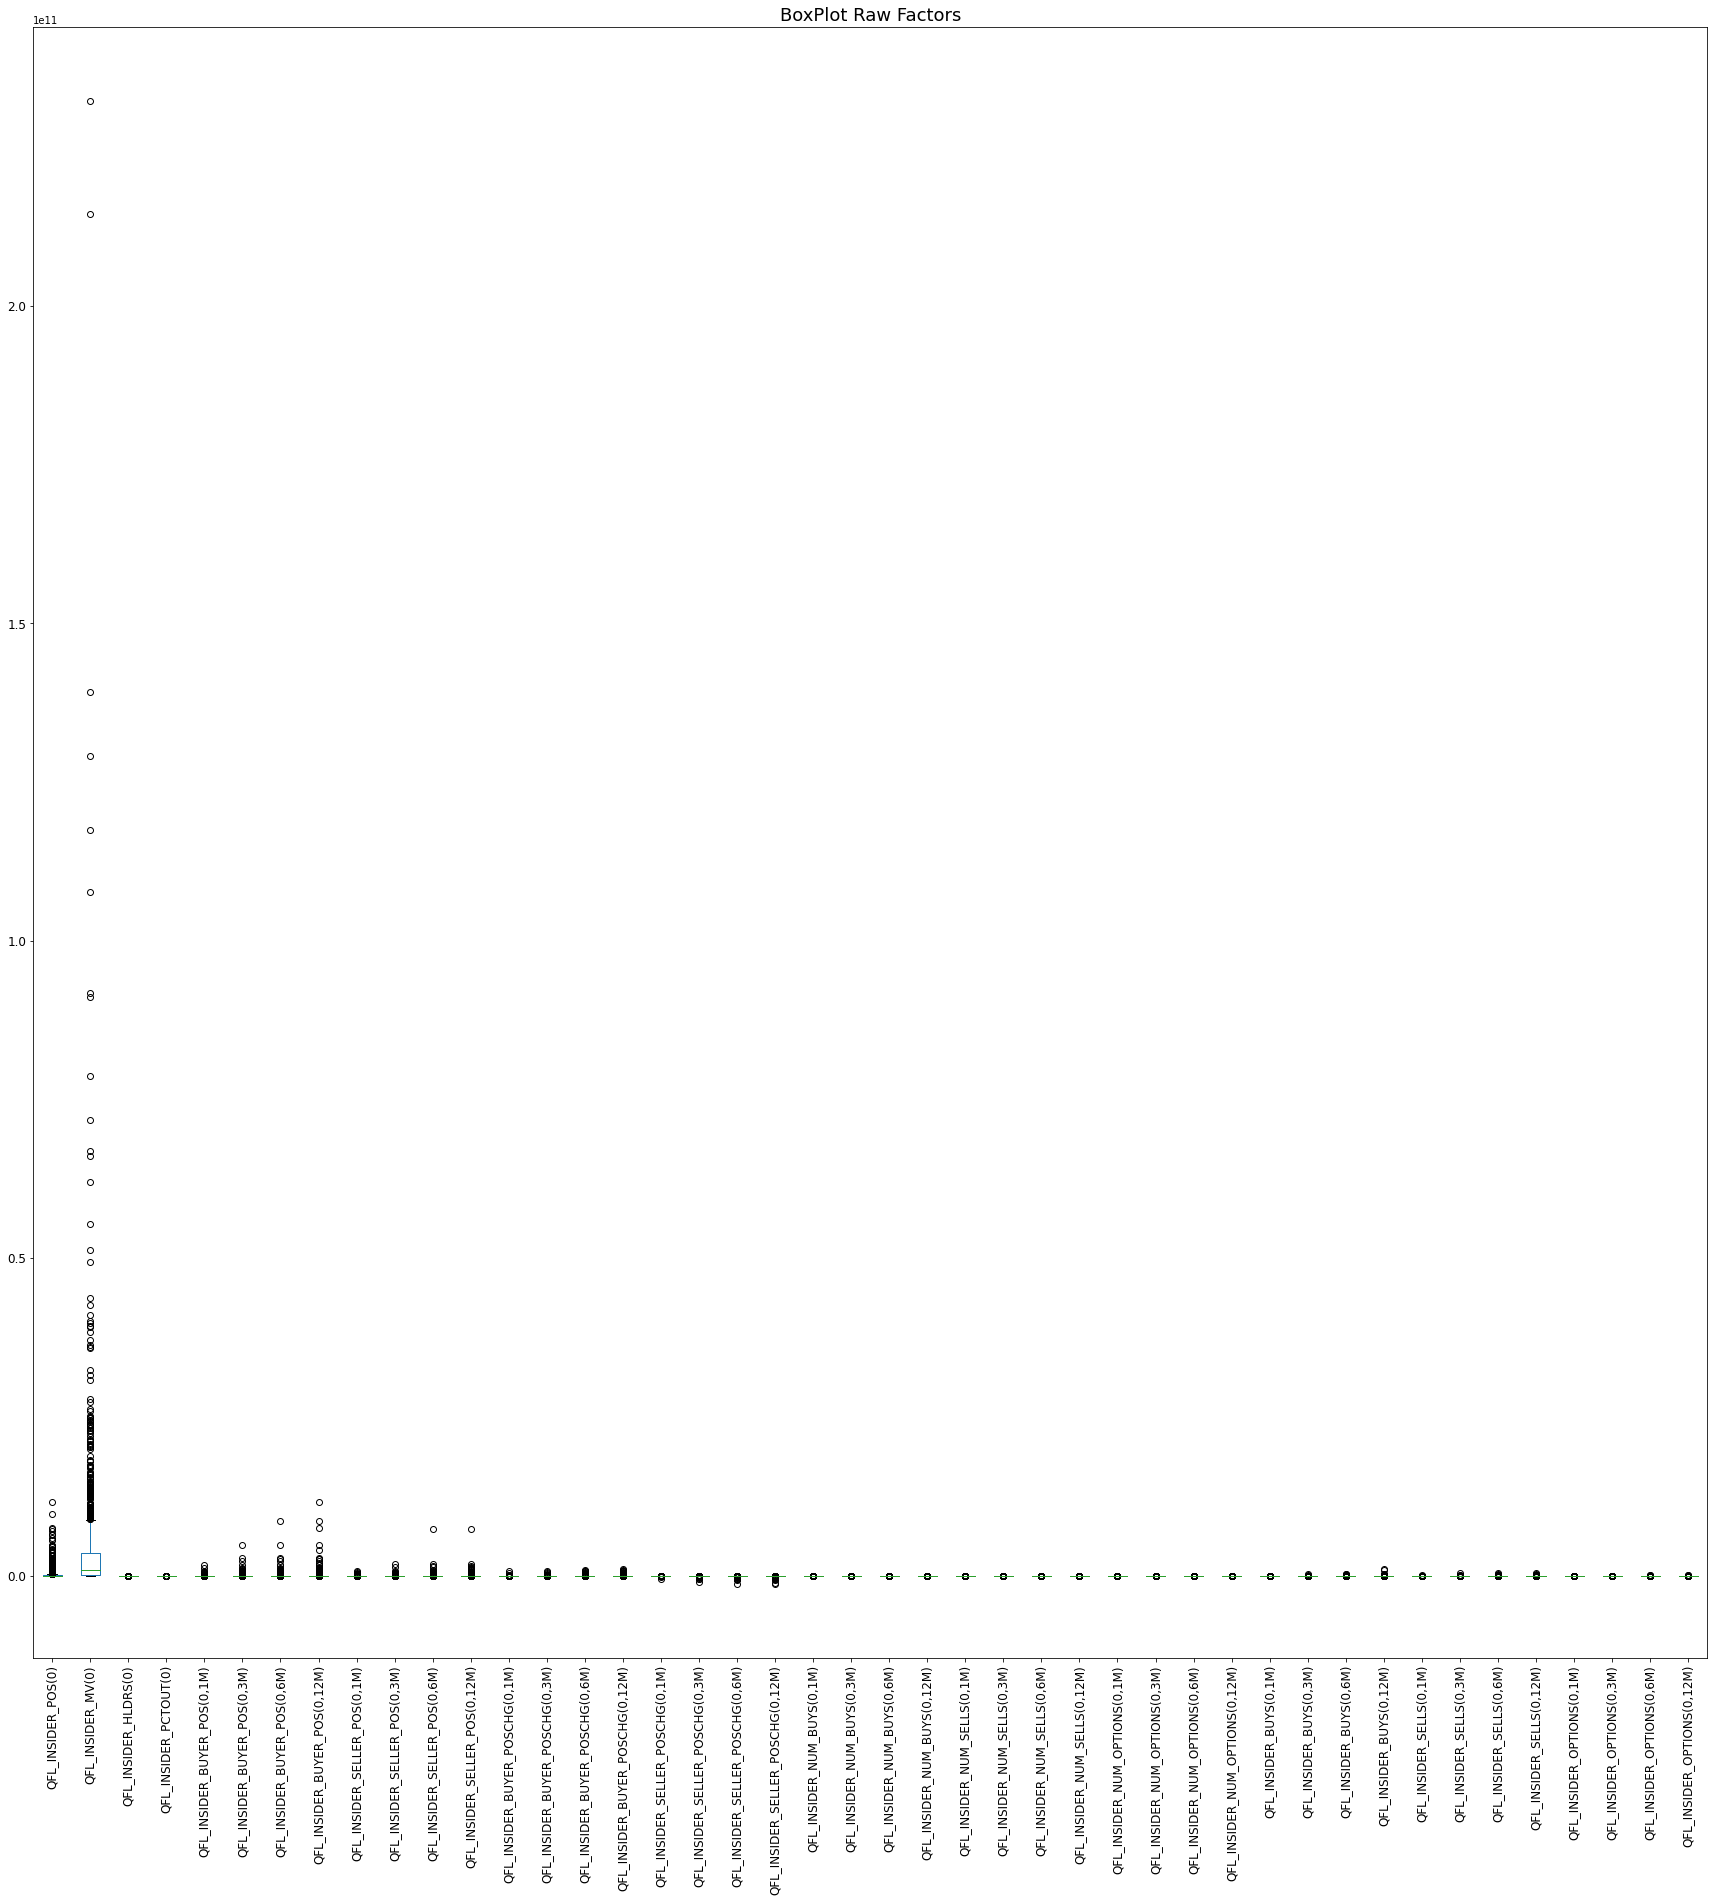

In [23]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [24]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)"
count,1.586000e+03,1.586000e+03,1.586000e+03,1.586000e+03,6.520000e+02,1.096000e+03,1.285000e+03,1.505000e+03,6.110000e+02,1.015000e+03,1.200000e+03,1.452000e+03,6.520000e+02,1.096000e+03,1.285000e+03,1.505000e+03,6.110000e+02,1.015000e+03,1.200000e+03,1.452000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03
mean,-1.107423e-16,2.116144e-16,-1.409829e-16,-2.595654e-16,1.064248e-18,7.040192e-18,-4.311294e-17,-7.198930e-17,2.175928e-17,4.316471e-17,3.967313e-17,-8.003622e-17,2.786200e-17,-2.940166e-17,-1.758213e-17,-1.945657e-17,-1.564942e-17,-4.156500e-18,1.510366e-17,-5.333199e-18,-5.729216e-16,4.856344e-16,-5.611423e-16,9.120193e-17,1.155683e-15,-3.153979e-16,2.223409e-15,1.165523e-15,3.507148e-15,2.643657e-15,-2.167545e-15,-2.041992e-15,-5.783881e-17,6.136116e-16,9.217179e-17,6.743159e-17,2.828459e-17,-3.112363e-16,-1.718941e-16,2.519162e-16,1.548423e-16,2.057334e-16,-8.058639e-18,-4.115725e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.809989e-01,-3.292665e-01,-4.593090e-01,-8.180435e-01,-1.557996e-01,-1.456594e-01,-1.323888e-01,-1.405249e-01,-2.098722e-01,-1.762927e-01,-1.021680e-01,-1.281151e-01,-9.039845e-02,-1.189566e-01,-1.470685e-01,-1.877700e-01,-1.958465e+01,-2.484383e+01,-2.416066e+01,-2.144003e+01,-1.795893e-01,-2.408732e-01,-2.460092e-01,-3.086458e-01,-1.464149e-01,-2.107952e-01,-2.253656e-01,-2.583654e-01,-2.934290e-01,-3.829336e-01,-4.227609e-01,-5.617884e-01,-6.565090e-02,-4.183942e-02,-5.696155e-02,-6.061673e-02,-6.935908e-02,-5.889178e-02,-8.148818e-02,-1.170687e-01,-1.207667e-01,-8.306233e-02,-9.034968e-02,-1.659519e-01
25%,-2.783521e-01,-3.176694e-01,-2.718285e-01,-7.865705e-01,-1.553936e-01,-1.451433e-01,-1.317967e-01,-1.394198e-01,-2.092579e-01,-1.757638e-01,-1.019007e-01,-1.278019e-01,-9.032403e-02,-1.187582e-01,-1.466732e-01,-1.862929e-01,1.252685e-01,1.025738e-01,1.218254e-01,1.164495e-01,-1.795893e-01,-2.408732e-01,-2.460092e-01,-3.086458e-01,-1.46414

In [25]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)"
0,14.824956,18.200242,22.328097,3.459938,17.096790,22.830775,26.457272,23.631184,13.444651,21.729378,31.333882,32.896784,20.616404,20.221703,18.337381,17.710457,0.136540,0.118041,0.146211,0.183508,20.011380,13.712232,16.519147,15.475746,30.621160,20.645390,24.132925,23.584023,11.956940,9.226405,11.254559,10.384781,31.206400,36.044742,27.656086,29.683299,32.642581,36.929951,32.538552,27.490106,29.300896,37.846076,27.665944,24.999750
1,12.473997,16.781273,18.800055,3.414373,12.478975,13.156751,14.707873,17.516670,11.410246,15.172278,8.054363,8.440665,13.471928,17.714295,14.279306,14.673480,0.136540,0.118041,0.146211,0.183508,13.866303,13.112099,11.983646,11.472458,13.645946,18.050093,13.824052,10.579084,9.762844,8.453240,8.955397,8.467742,17.944285,16.232711,24.242365,22.406413,14.657594,9.051120,16.990950,17.271835,21.290406,9.454976,26.236665,23.805047
2,9.594003,10.775379,14.061910,3.355185,6.963257,11.318030,8.461118,15.378097,7.234278,7.924151,6.223112,6.516859,5.366826,13.288272,13.585321,11.890386,0.136539,0.118041,0.146211,0.183508,11.232698,10.861598,11.578690,9.756763,11.108890,9.482484,10.316172,10.184995,9.397162,7.127814,8.047834,7.217500,9.192237,1.472565,12.441240,8.548789,11.858048,8.215740,7.959048,11.259574,7.046244,2.989070,6.472518,7.702290
3,9.423158,9.973364,10.039601,3.287072,6.236830,7.973108,8.048633,9.714336,6.186730,6.679597,5.612840,6.342869,1.980342,9.477226,11.891822,11.410950,0.136537,0.118040,0.146211,0.183507,10.793764,10.561531,9.877877,8.841726,9.955682,9.451216,8.257977,9.123144,9.031479,6.796458,7.684808,7.134150,7.855204,1.146289,7.088677,7.487083,8.578755,3.503837,7.221213,10.157953,6.395809,2.399784,4.416889,7.688239
4,8.834981,9.046495,7.193305,3.177151,6.198059,5.800045,7.271900,8.193390,5.742983,4.804710,3.996911,5.157410,1.215142,5.241772,9.939278,10.885585,0.136537,0.118040,0.146211,0.183507,10.354830,8.911164,8.744002,8.041069,4.835441,8.419351,6.897779,8.324019,8.665796,6.686005,7.503295,6.272872,6.708414,1.051648,1.988386,4.209250,6.658263,2.895489,5.737316,8.904411,3.968497,1.757203,3.708563,7.529967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [26]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)"
0,-0.280999,-0.329267,-0.459309,-0.818044,-0.155800,-0.145659,-0.132389,-0.140525,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118957,-0.147069,-0.187770,-19.584653,-24.843835,-24.160656,-21.440028,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952
1,-0.280986,-0.329229,-0.459309,-0.818044,-0.155799,-0.145659,-0.132388,-0.140525,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118957,-0.147068,-0.187769,-10.929844,-10.974565,-11.886157,-20.226820,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952
2,-0.280980,-0.329217,-0.459309,-0.817574,-0.155799,-0.145659,-0.132385,-0.140525,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118957,-0.147068,-0.187769,-4.546191,-10.906383,-9.486474,-10.909572,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952
3,-0.280975,-0.329196,-0.459309,-0.817574,-0.155799,-0.145658,-0.132383,-0.140523,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118957,-0.147068,-0.187769,-4.336489,-7.810136,-9.472734,-8.942887,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952
4,-0.280965,-0.329136,-0.459309,-0.817574,-0.155798,-0.145658,-0.132383,-0.140523,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118956,-0.147068,-0.187769,-3.854634,-4.301778,-8.610969,-7.613856,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

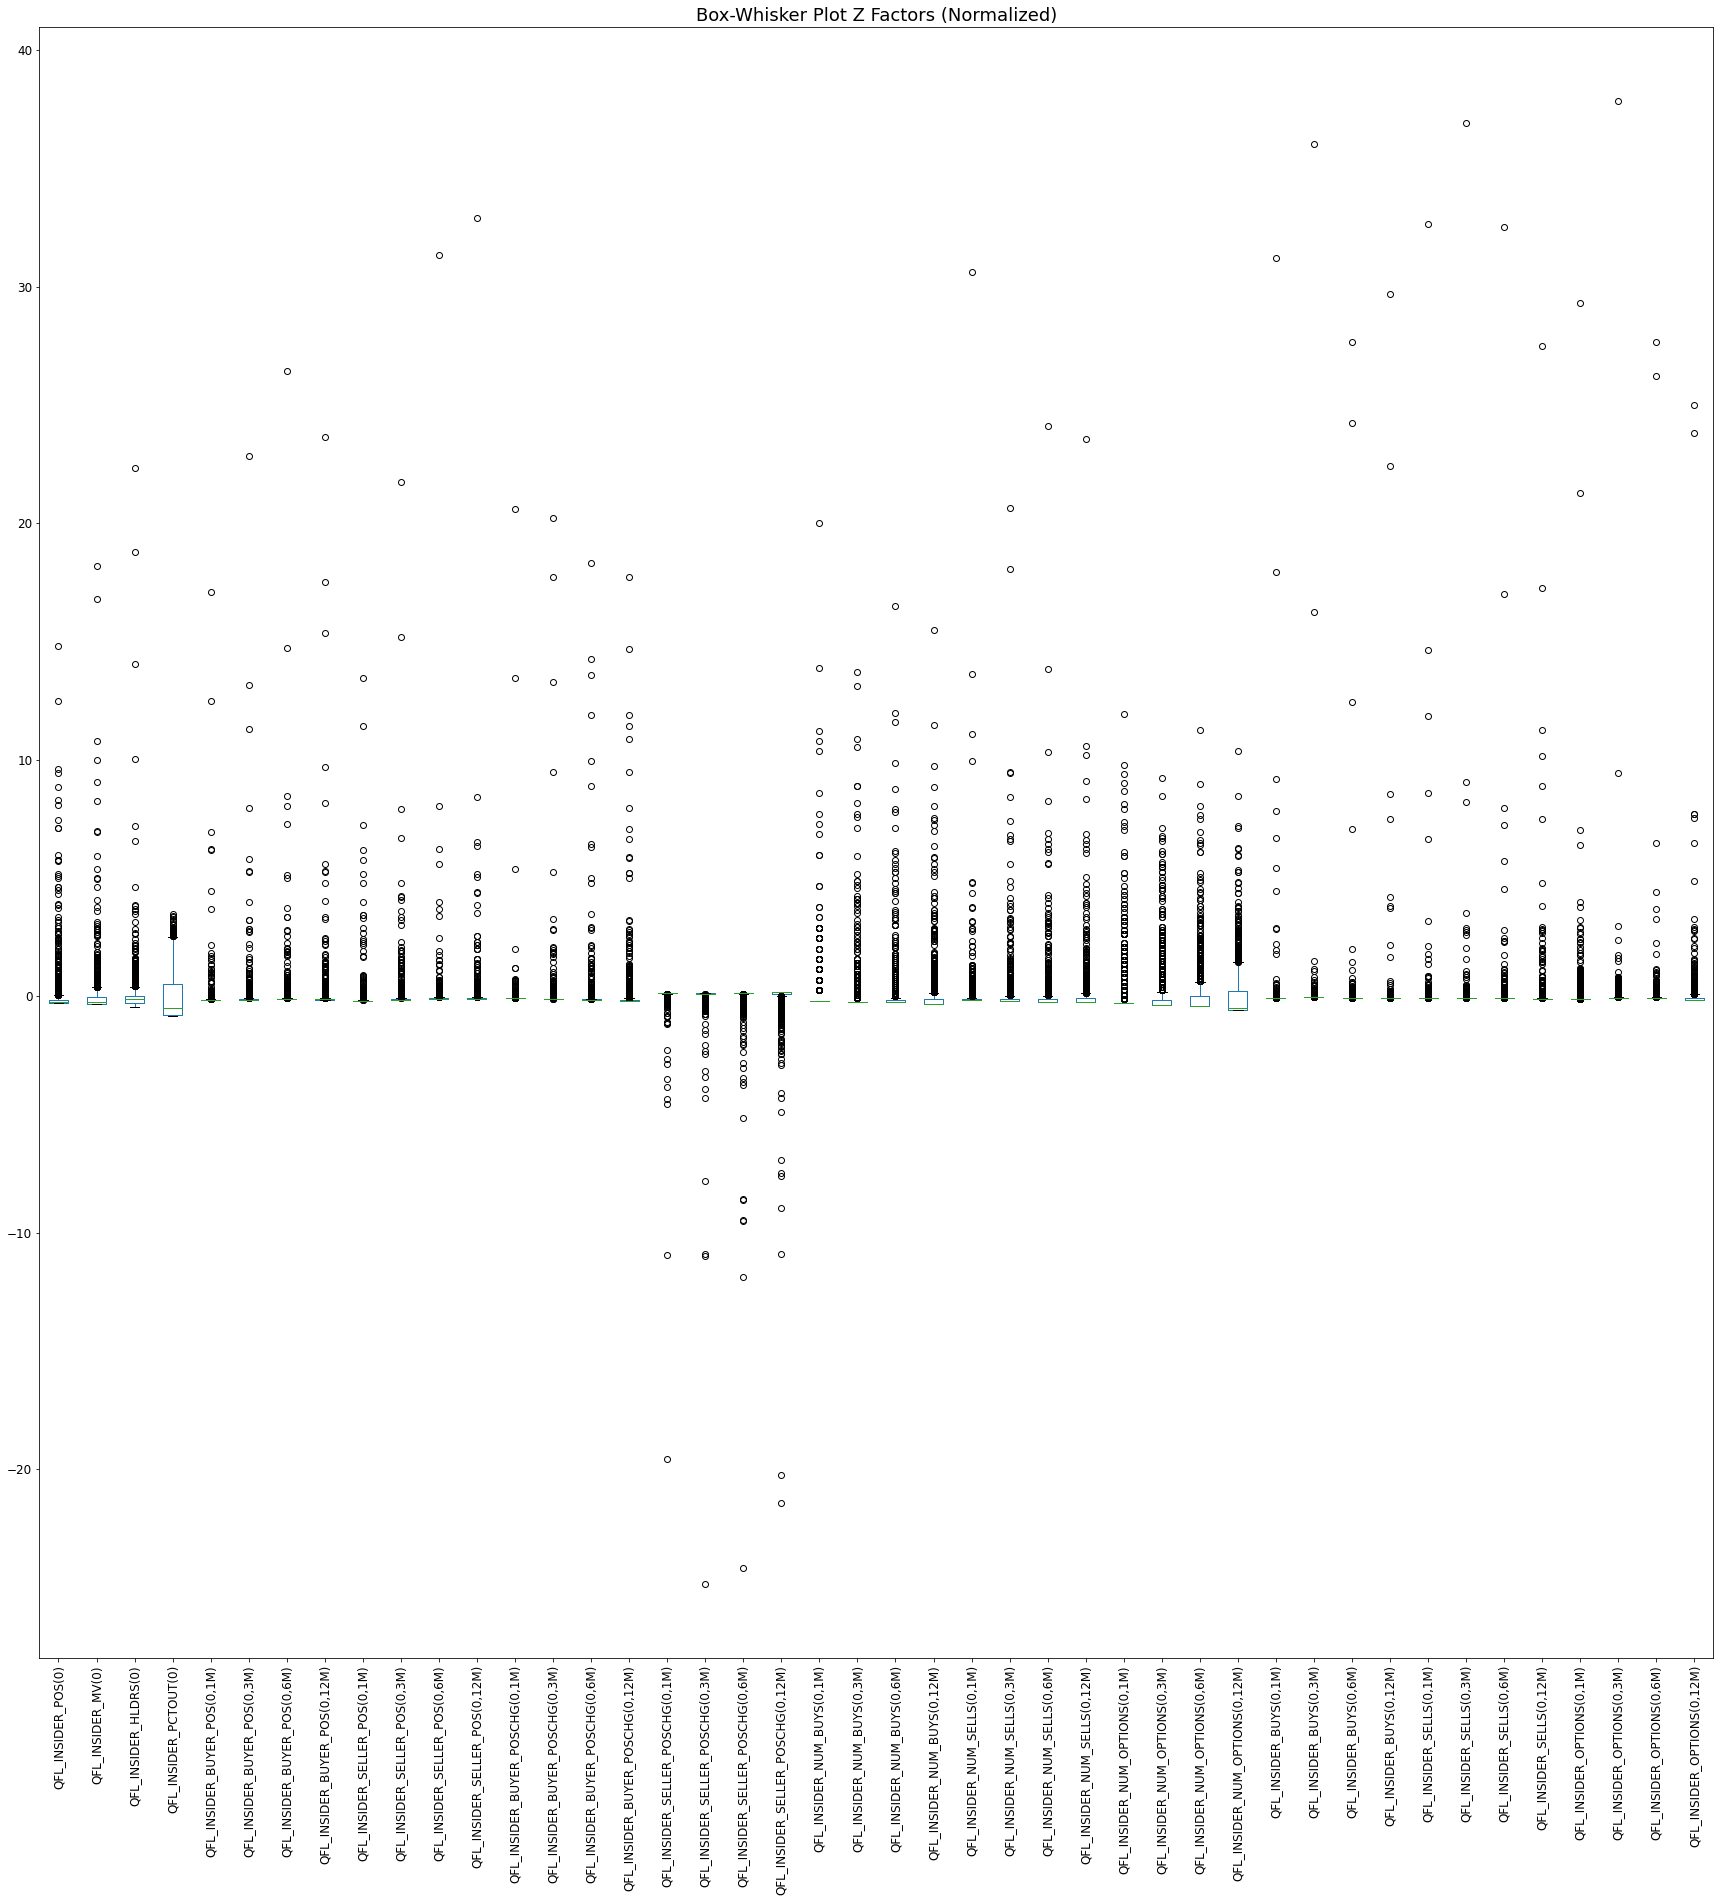

In [27]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [28]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)",MFR
0,-0.280999,-0.329267,-0.459309,-0.818044,-0.155800,-0.145659,-0.132389,-0.140525,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118957,-0.147069,-0.187770,-19.584653,-24.843835,-24.160656,-21.440028,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952,-2.230472
1,-0.280986,-0.329229,-0.459309,-0.818044,-0.155799,-0.145659,-0.132388,-0.140525,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118957,-0.147068,-0.187769,-10.929844,-10.974565,-11.886157,-20.226820,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952,-1.412021
2,-0.280980,-0.329217,-0.459309,-0.817574,-0.155799,-0.145659,-0.132385,-0.140525,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118957,-0.147068,-0.187769,-4.546191,-10.906383,-9.486474,-10.909572,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952,-0.999084
3,-0.280975,-0.329196,-0.459309,-0.817574,-0.155799,-0.145658,-0.132383,-0.140523,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118957,-0.147068,-0.187769,-4.336489,-7.810136,-9.472734,-8.942887,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952,-0.878938
4,-0.280965,-0.329136,-0.459309,-0.817574,-0.155798,-0.145658,-0.132383,-0.140523,-0.209872,-0.176293,-0.102168,-0.128115,-0.090398,-0.118956,-0.147068,-0.187769,-3.854634,-4.301778,-8.610969,-7.613856,-0.179589,-0.240873,-0.246009,-0.308646,-0.146415,-0.210795,-0.225366,-0.258365,-0.293429,-0.382934,-0.422761,-0.561788,-0.065651,-0.041839,-0.056962,-0.060617,-0.069359,-0.058892,-0.081488,-0.117069,-0.120767,-0.083062,-0.09035,-0.165952,-0.738459


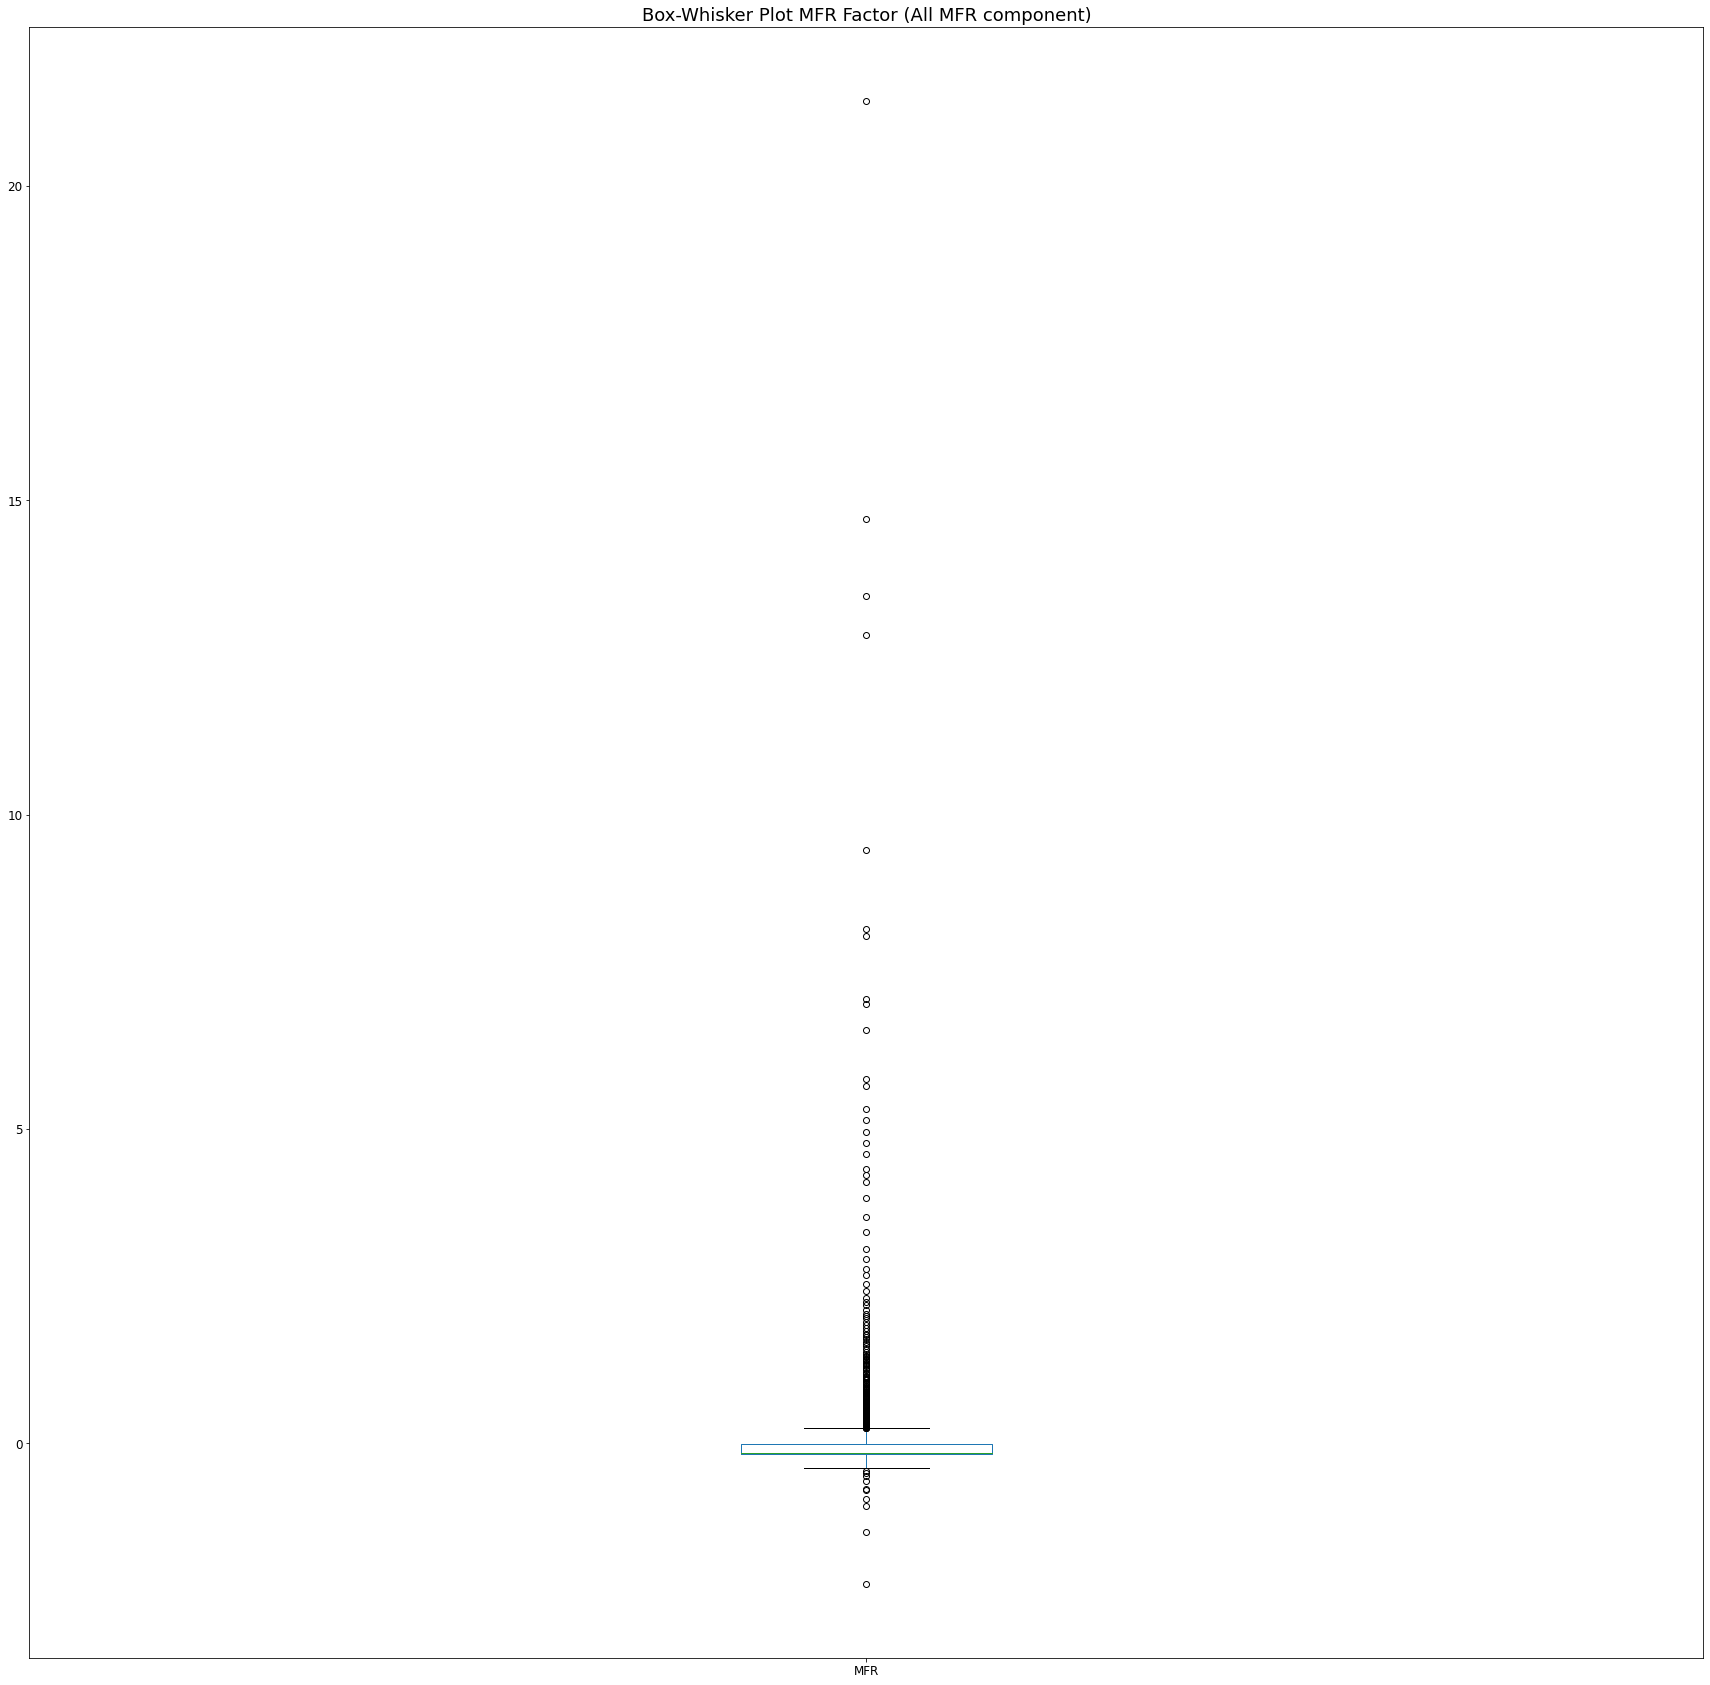

In [29]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

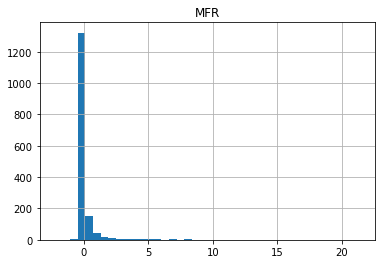

In [30]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.06
Information Coefficient (P-Value): 0.02


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


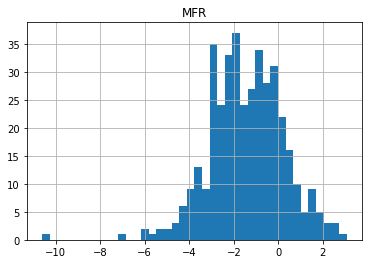

In [32]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [33]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)"
0,16.616483,21.396026,2.890372,0.10,12.716954,12.817622,12.716954,14.903464,26876.0,4628476.0,9863781.0,8870957.0,12.399977,12.426272,12.399977,13.387333,-2604.0,-508068.0,-3586075.0,-10727095.0,0.0,0.0,0.0,0.0,3.0,9.0,17.0,41.0,2.0,12.0,14.0,30.0,0.0,0.0,0.0,0.0,17000.0,563814.0,1624454.0,2013178.0,88004.0,2487946.0,5907306.0,7283438.0
1,18.533317,23.899620,3.433987,1.48,11.677125,14.601066,14.593133,15.282611,2172707.0,2113555.0,5416984.0,4092332.0,11.533120,12.540117,12.776422,13.183897,-309678.0,-1107972.0,-1292188.0,-3982342.0,0.0,0.0,0.0,0.0,4.0,12.0,16.0,35.0,0.0,9.0,11.0,24.0,0.0,0.0,0.0,0.0,304500.0,414542.0,475616.0,851844.0,0.0,250821.0,252135.0,664804.0
2,18.110259,26.171127,3.295837,14.64,12.117602,12.233299,12.215676,12.924851,53353551.0,53373608.0,53378792.0,72897051.0,11.634639,11.651051,11.654121,11.837838,-1229423.0,-2631474.0,-2280734.0,-4628228.0,0.0,34.0,79.0,98.0,244.0,244.0,385.0,652.0,10.0,10.0,17.0,41.0,0.0,100.0,200.0,400.0,1016312.0,1016312.0,2030117.0,4072070.0,9317.0,9317.0,18249.0,51274.0
3,17.062457,22.686366,3.433987,1.07,16.113537,16.211367,16.205328,16.719506,5071190.0,4402321.0,4740228.0,6439837.0,11.229966,15.937611,15.947951,15.941605,-243209.0,-338889.0,-5493937.0,-13663010.0,0.0,0.0,0.0,0.0,299.0,309.0,327.0,369.0,42.0,42.0,82.0,164.0,0.0,0.0,0.0,0.0,715770.0,732714.0,752429.0,919577.0,353401.0,353401.0,673028.0,1372956.0
4,17.523995,24.997485,2.890372,12.23,7.737616,12.201457,13.054917,13.052336,19230424.0,19430808.0,20263513.0,20311047.0,4.605170,8.904766,12.099211,12.182871,-9960.0,-4108413.0,-4400632.0,-4417176.0,0.0,0.0,0.0,0.0,1.0,3.0,33.0,123.0,0.0,6.0,14.0,35.0,0.0,0.0,0.0,0.0,20.0,62.0,228.0,58462.0,0.0,9228.0,21130.0,98739.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,16.540214,19.462806,2.564949,10.55,9.992871,16.526485,16.526485,16.526585,15003563.0,1500.0,1500.0,NaN,9.286375,13.216891,13.557465,13.993588,-421220.0,-1000.0,-1000.0,NaN,0.0,21.0,32.0,163.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,430300.0,960080.0,1602680.0,0.0,0.0,0.0,762.0,0.0,0.0,0.0,0.0
1596,20.266406,21.055400,2.772589,53.70,NaN,15.093012,15.093012,15.093012,NaN,NaN,NaN,0.0,NaN,14.841243,14.841243,14.841243,NaN,NaN,NaN,-5000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,15.253892,17.740032,2.944439,1.93,NaN,15.092923,15.092923,15.235529,NaN,137824.0,137824.0,28424.0,NaN,14.599837,14.599837,14.153235,NaN,-25876.0,-14662625.0,-21666459.0,0.0,10.0,16.0,35.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,7.0,0.0,61550.0,78550.0,197602.0,0.0,0.0,0.0,81826.0,0.0,0.0,0.0,27200.0
15

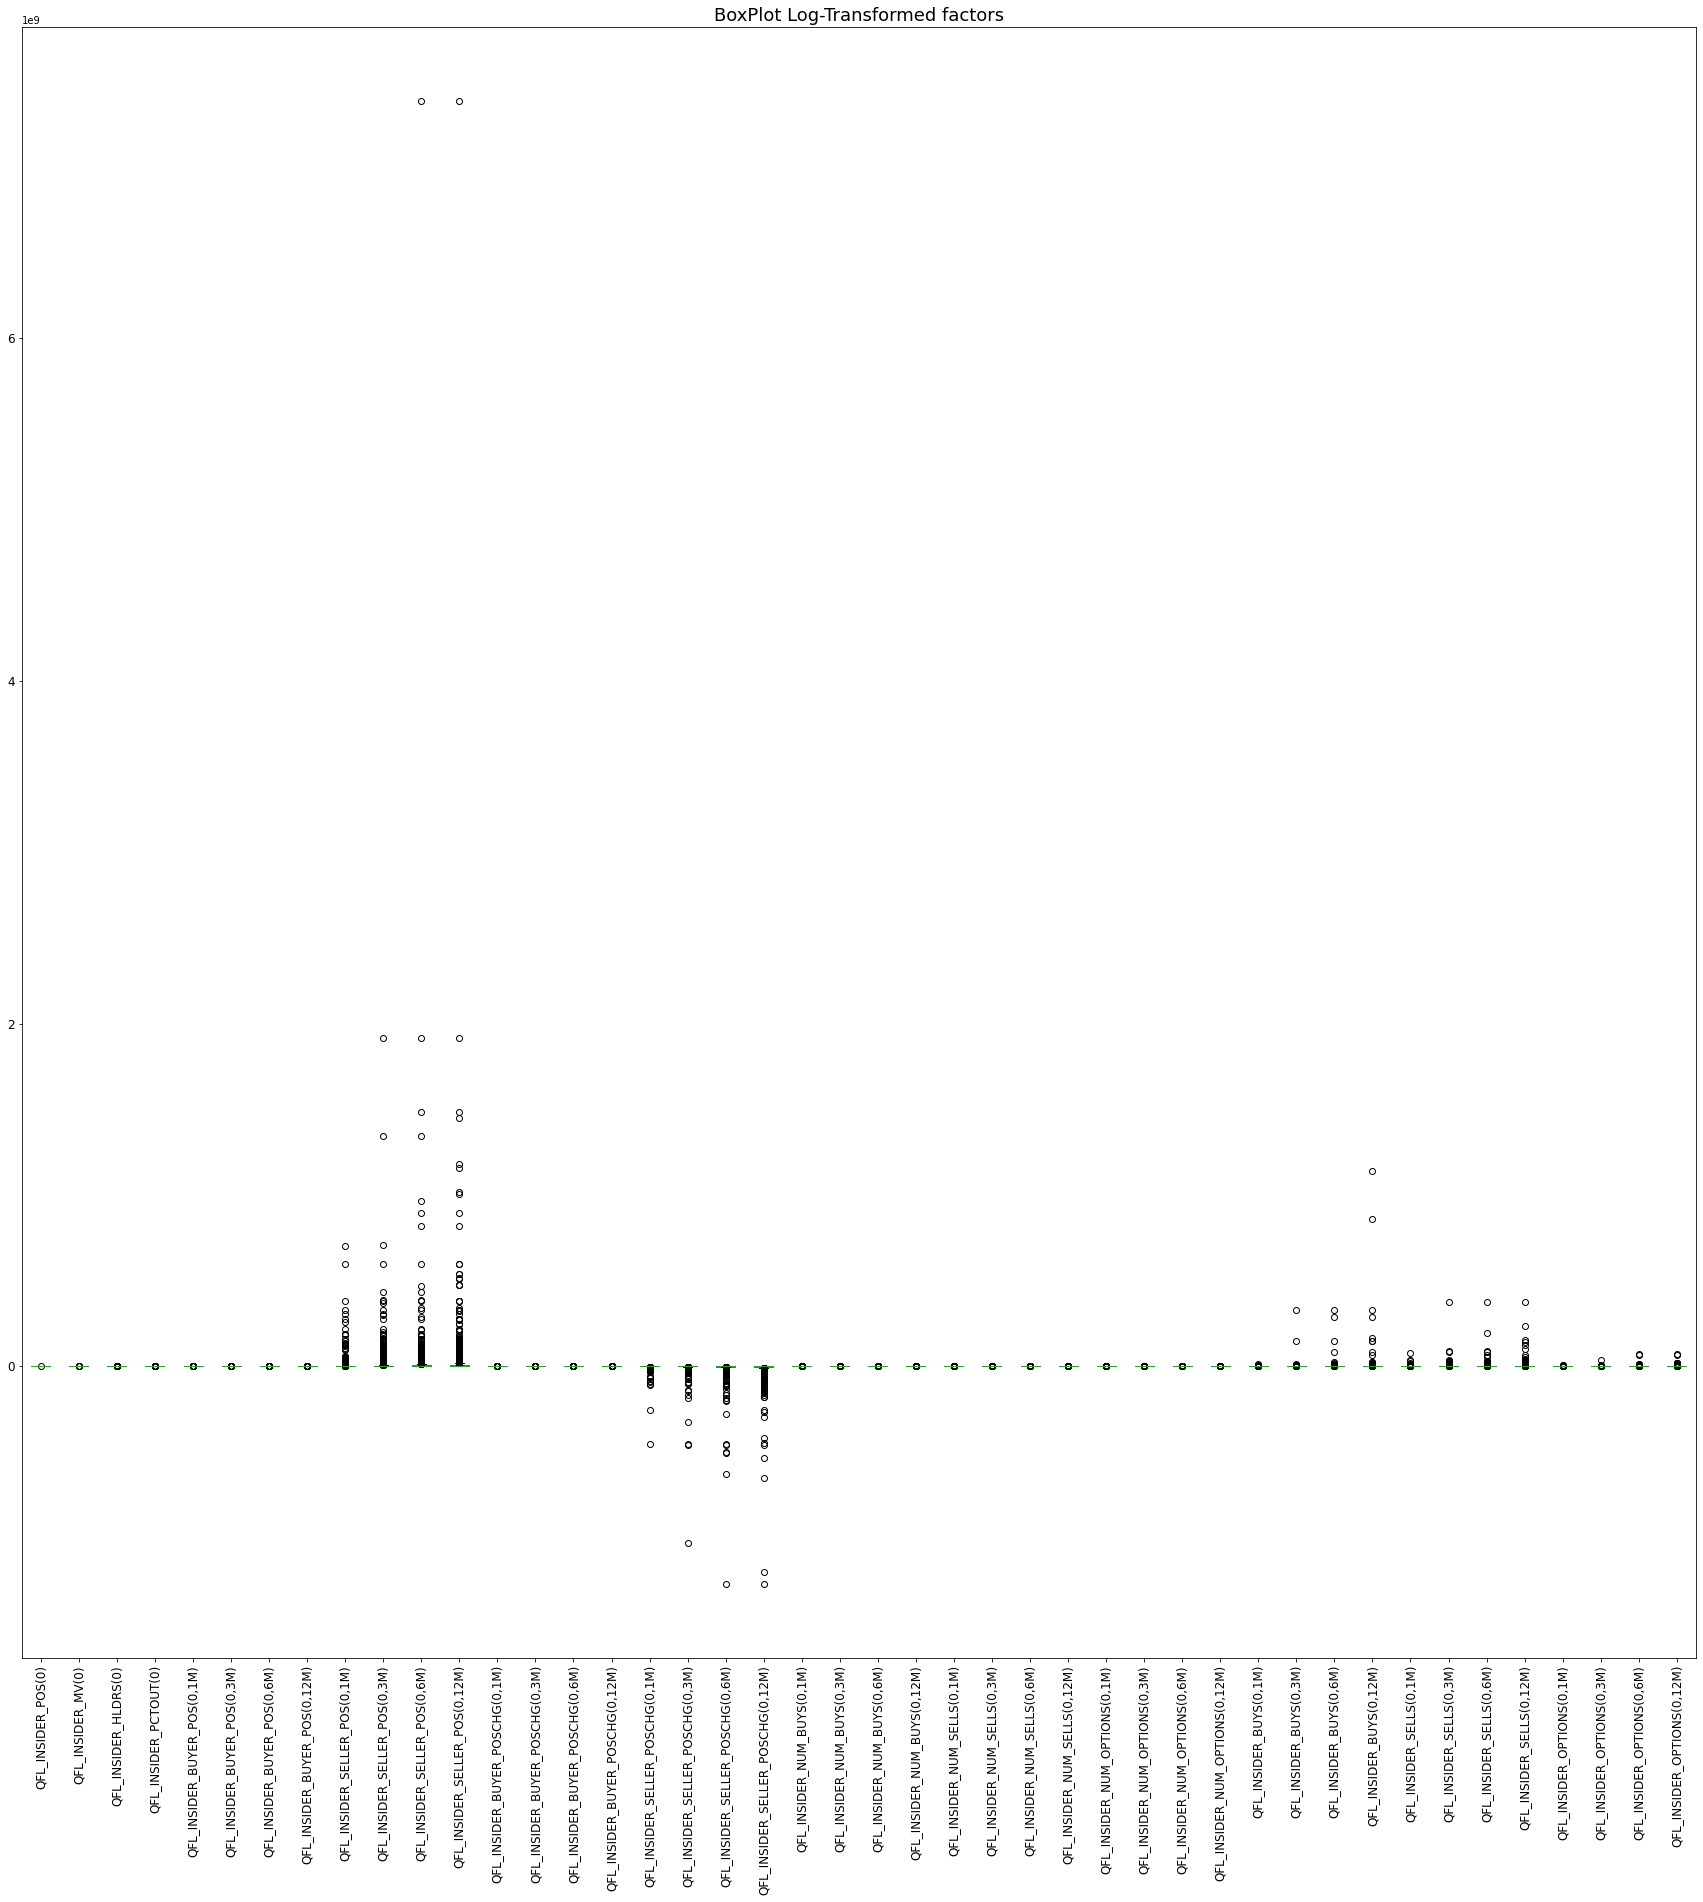

In [34]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [35]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)",MFR
0,0.005415,0.463919,0.053846,-0.813346,0.059959,-0.208002,-0.442338,0.022707,-0.209351,-0.123344,-0.060152,-0.088419,0.848763,0.542356,0.228708,0.104264,0.136427,0.105705,0.077471,0.000609,-0.179589,-0.240873,-0.246009,-0.308646,-0.008030,0.070623,0.078889,0.190458,0.072254,0.942492,0.424299,0.271707,-0.065651,-0.041839,-0.056962,-0.060617,-0.062408,-0.003368,0.059592,0.030903,0.194596,2.399784,2.257653,2.458830,0.201893
1,0.765873,1.683865,0.608129,-0.748521,-0.295308,0.405065,0.255781,0.176573,-0.167744,-0.152114,-0.079094,-0.109802,0.566379,0.579484,0.358157,0.024670,0.123089,0.091139,0.121442,0.115608,-0.179589,-0.240873,-0.246009,-0.308646,0.038098,0.164429,0.060992,0.124777,-0.293429,0.611136,0.242786,0.105008,-0.065651,-0.041839,-0.056962,-0.060617,0.055151,-0.018068,-0.040182,-0.054457,-0.120767,0.167245,0.009868,0.073628,0.096561
2,0.598034,2.790720,0.467268,-0.130335,-0.144815,-0.408865,-0.628862,-0.780256,0.824627,0.434293,0.125204,0.198091,0.599449,0.289533,-0.027772,-0.501972,0.083140,0.054148,0.102493,0.104596,-0.179589,4.860262,6.152287,3.427756,11.108890,7.418754,6.665113,6.879026,1.534984,0.721588,0.605811,0.577322,-0.065651,-0.041828,-0.056945,-0.060606,0.346210,0.041194,0.094823,0.182235,-0.087379,-0.073764,-0.083096,-0.147474,1.224287
3,0.182344,1.092673,0.608129,-0.767781,1.220432,0.958614,0.855673,0.759696,-0.111544,-0.125931,-0.081977,-0.099298,0.467624,1.687508,1.448762,1.103617,0.125976,0.109813,0.040900,-0.049449,-0.179589,-0.240873,-0.246009,-0.308646,13.645946,9.451216,5.627067,3.781048,7.385907,4.256058,4.538587,3.994652,-0.065651,-0.041839,-0.056962,-0.060617,0.223319,0.013265,-0.016141,-0.049478,1.145648,0.269614,0.177162,0.328830,1.431779
4,0.365449,2.218830,0.053846,-0.243543,-1.641277,-0.419811,-0.316583,-0.728520,0.162996,0.045993,-0.015854,-0.037225,-1.690444,-0.606112,0.125282,-0.366979,0.136107,0.018287,0.061857,0.108194,-0.179589,-0.240873,-0.246009,-0.308646,-0.100287,-0.116989,0.365247,1.088106,-0.293429,0.279779,0.424299,0.410623,-0.065651,-0.041839,-0.056962,-0.060617,-0.069351,-0.058886,-0.081468,-0.112772,-0.120767,-0.073853,-0.081951,-0.130369,-0.060040


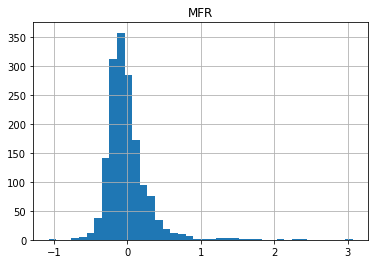

In [36]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [37]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.01
Information Coefficient (P-Value): 0.68


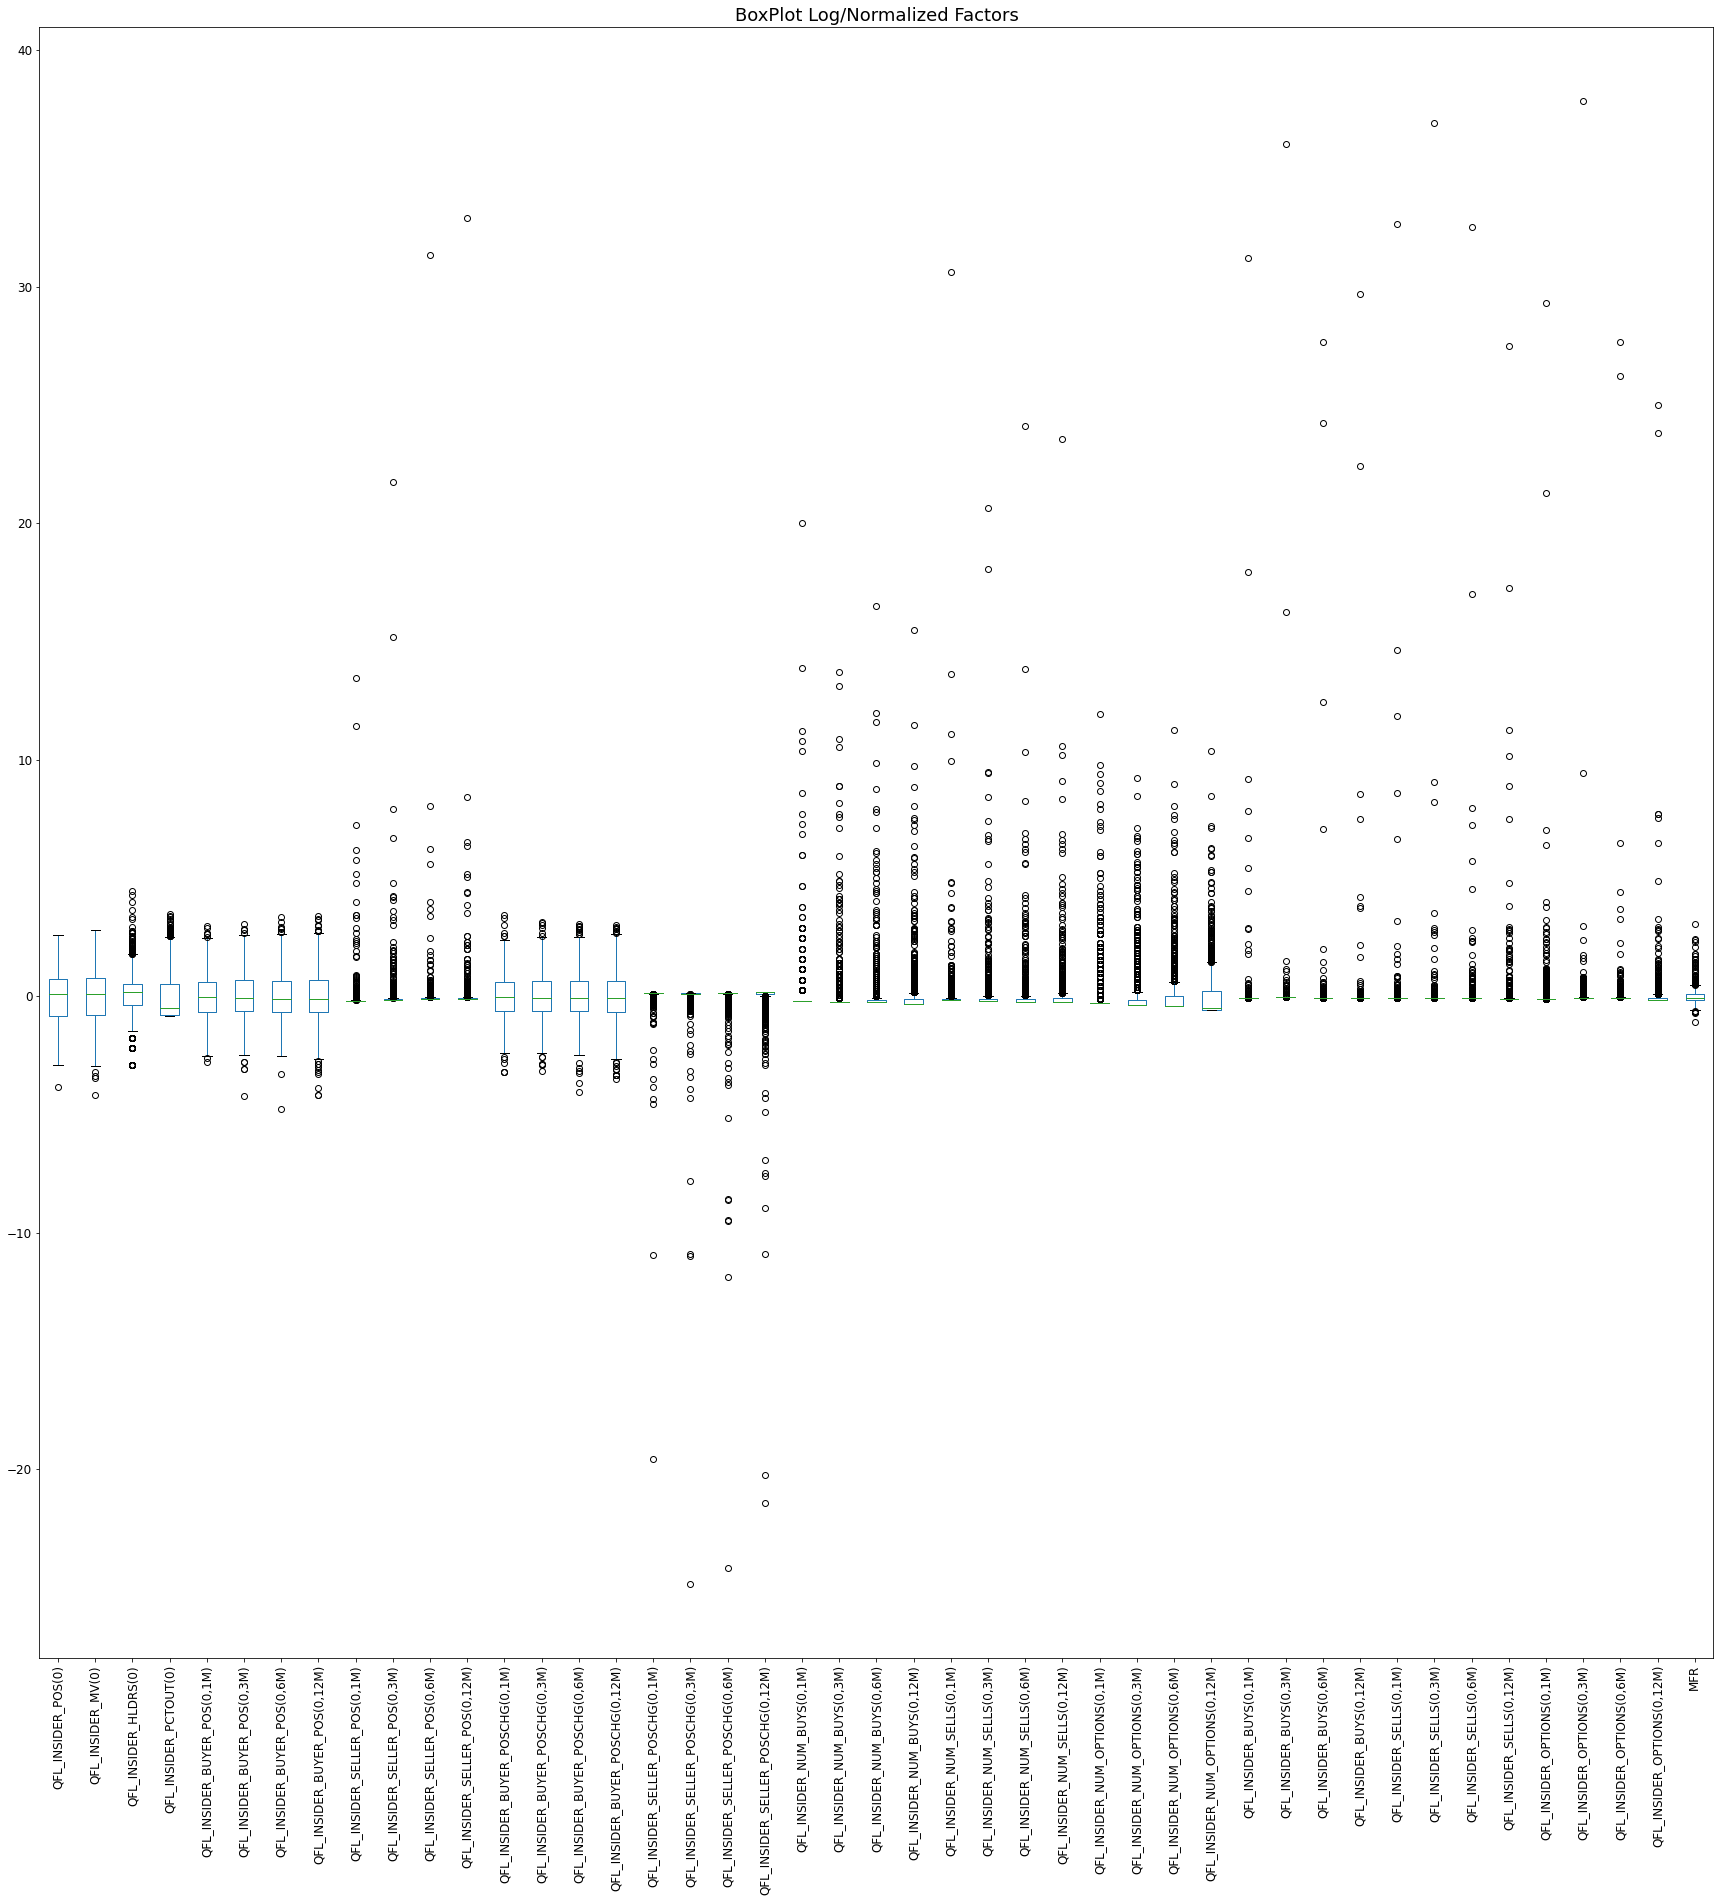

In [38]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [39]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_INSIDER_POS(0),QFL_INSIDER_MV(0),QFL_INSIDER_HLDRS(0),QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_BUYER_POS(0,1M)","QFL_INSIDER_BUYER_POS(0,3M)","QFL_INSIDER_BUYER_POS(0,6M)","QFL_INSIDER_BUYER_POS(0,12M)","QFL_INSIDER_SELLER_POS(0,1M)","QFL_INSIDER_SELLER_POS(0,3M)","QFL_INSIDER_SELLER_POS(0,6M)","QFL_INSIDER_SELLER_POS(0,12M)","QFL_INSIDER_BUYER_POSCHG(0,1M)","QFL_INSIDER_BUYER_POSCHG(0,3M)","QFL_INSIDER_BUYER_POSCHG(0,6M)","QFL_INSIDER_BUYER_POSCHG(0,12M)","QFL_INSIDER_SELLER_POSCHG(0,1M)","QFL_INSIDER_SELLER_POSCHG(0,3M)","QFL_INSIDER_SELLER_POSCHG(0,6M)","QFL_INSIDER_SELLER_POSCHG(0,12M)","QFL_INSIDER_NUM_BUYS(0,1M)","QFL_INSIDER_NUM_BUYS(0,3M)","QFL_INSIDER_NUM_BUYS(0,6M)","QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_SELLS(0,1M)","QFL_INSIDER_NUM_SELLS(0,3M)","QFL_INSIDER_NUM_SELLS(0,6M)","QFL_INSIDER_NUM_SELLS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,1M)","QFL_INSIDER_NUM_OPTIONS(0,3M)","QFL_INSIDER_NUM_OPTIONS(0,6M)","QFL_INSIDER_NUM_OPTIONS(0,12M)","QFL_INSIDER_BUYS(0,1M)","QFL_INSIDER_BUYS(0,3M)","QFL_INSIDER_BUYS(0,6M)","QFL_INSIDER_BUYS(0,12M)","QFL_INSIDER_SELLS(0,1M)","QFL_INSIDER_SELLS(0,3M)","QFL_INSIDER_SELLS(0,6M)","QFL_INSIDER_SELLS(0,12M)","QFL_INSIDER_OPTIONS(0,1M)","QFL_INSIDER_OPTIONS(0,3M)","QFL_INSIDER_OPTIONS(0,6M)","QFL_INSIDER_OPTIONS(0,12M)",ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,16460641.0,1.959639e+09,18.0,0.10,333352.0,368657.0,333352.0,2968192.0,26876.0,4628476.0,9863781.0,8870957.0,242796.0,249265.0,242796.0,651696.0,-2604.0,-508068.0,-3586075.0,-10727095.0,0.0,0.0,0.0,0.0,3.0,9.0,17.0,41.0,2.0,12.0,14.0,30.0,0.0,0.0,0.0,0.0,17000.0,563814.0,1624454.0,2013178.0,88004.0,2487946.0,5907306.0,7283438.0,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,111922509.0,2.395925e+10,31.0,1.48,117845.0,2193624.0,2176292.0,4336643.0,2172707.0,2113555.0,5416984.0,4092332.0,102040.0,279321.0,353777.0,531733.0,-309678.0,-1107972.0,-1292188.0,-3982342.0,0.0,0.0,0.0,0.0,4.0,12.0,16.0,35.0,0.0,9.0,11.0,24.0,0.0,0.0,0.0,0.0,304500.0,414542.0,475616.0,851844.0,0.0,250821.0,252135.0,664804.0,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,73313761.0,2.322609e+11,27.0,14.64,183066.0,205520.0,201930.0,410385.0,53353551.0,53373608.0,53378792.0,72897051.0,112943.0,114812.0,115165.0,138391.0,-1229423.0,-2631474.0,-2280734.0,-4628228.0,0.0,34.0,79.0,98.0,244.0,244.0,385.0,652.0,10.0,10.0,17.0,41.0,0.0,100.0,200.0,400.0,1016312.0,1016312.0,2030117.0,4072070.0,9317.0,9317.0,18249.0,51274.0,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,25711701.0,7.121370e+09,31.0,1.07,9954513.0,10977599.0,10911501.0,18246901.0,5071190.0,4402321.0,4740228.0,6439837.0,75355.0,8348656.0,8435429.0,8382068.0,-243209.0,-338889.0,-5493937.0,-13663010.0,0.0,0.0,0.0,0.0,299.0,309.0,327.0,369.0,42.0,42.0,82.0,164.0,0.0,0.0,0.0,0.0,715770.0,732714.0,752429.0,919577.0,353401.0,353401.0,673028.0,1372956.0,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,40791948.0,7.182402e+10,18.0,12.23,2293.0,199079.0,467389.0,466184.0,19230424.0,19430808.0,20263513.0,20311047.0,100.0,7367.0,179730.0,195413.0,-9960.0,-4108413.0,-4400632.0,-4417176.0,0.0,0.0,0.0,0.0,1.0,3.0,33.0,123.0,0.0,6.0,14.0,35.0,0.0,0.0,0.0,0.0,20.0,62.0,228.0,58462.0,0.0,9228.0,21130.0,98739.0,1


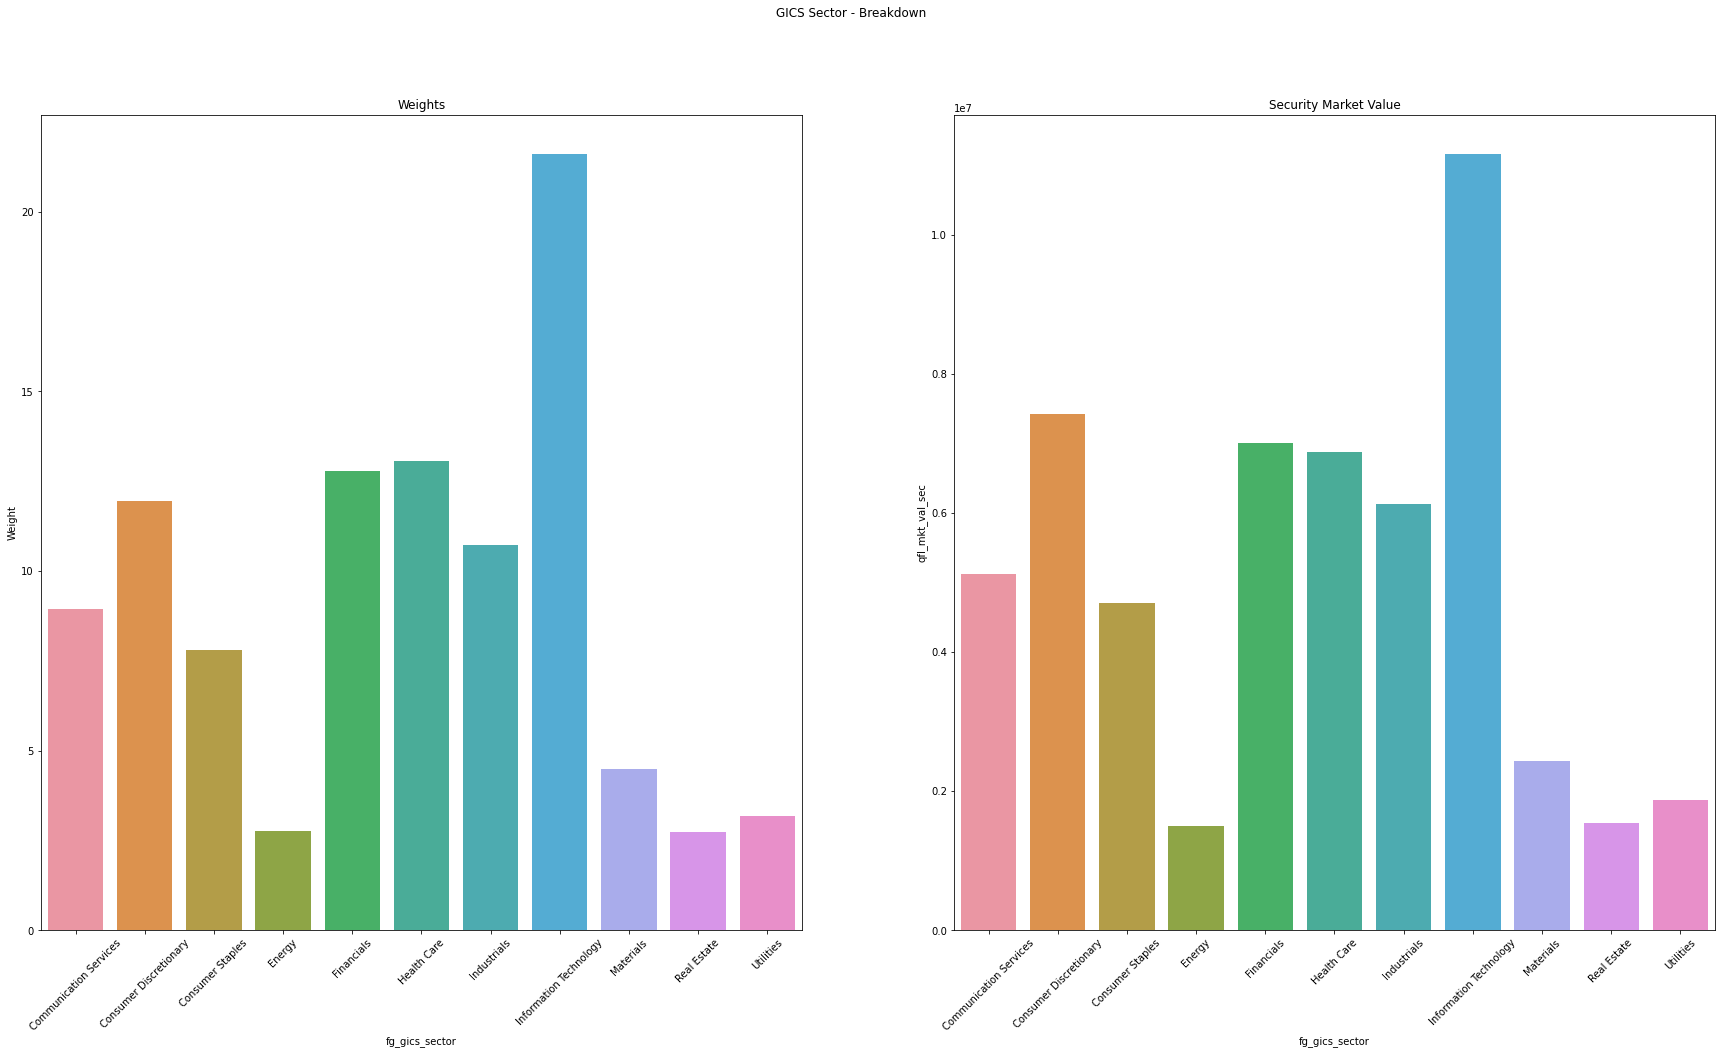

In [40]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

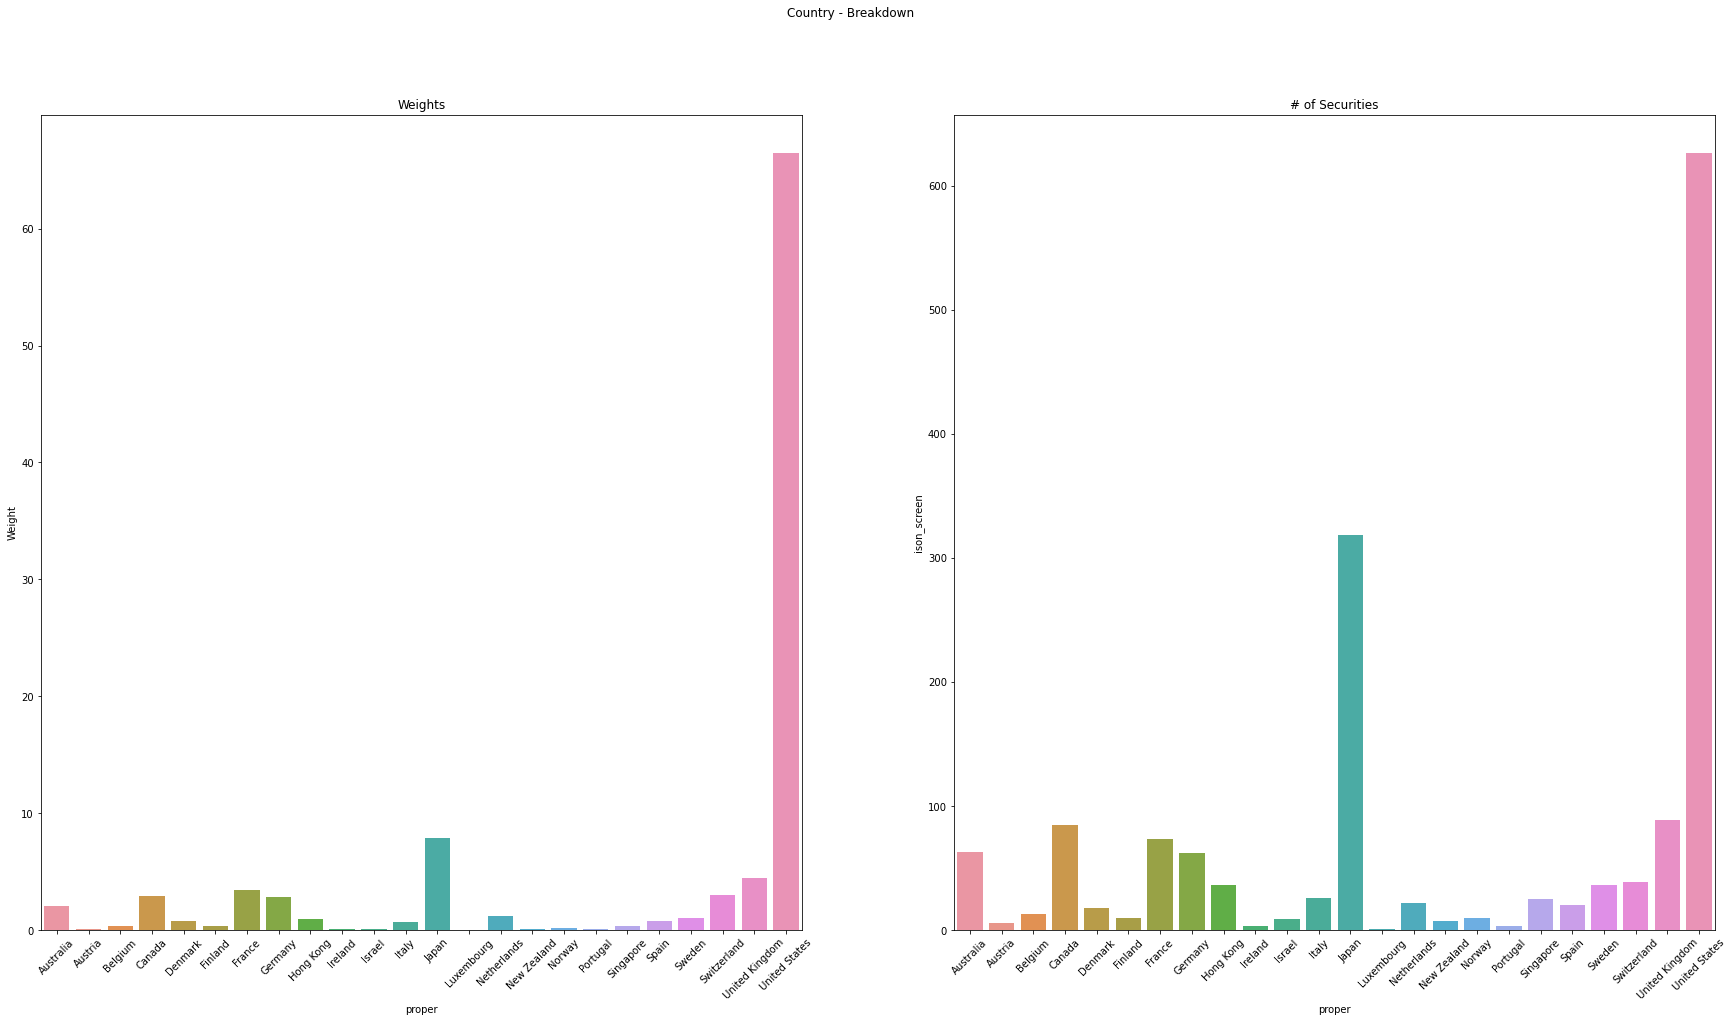

In [41]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

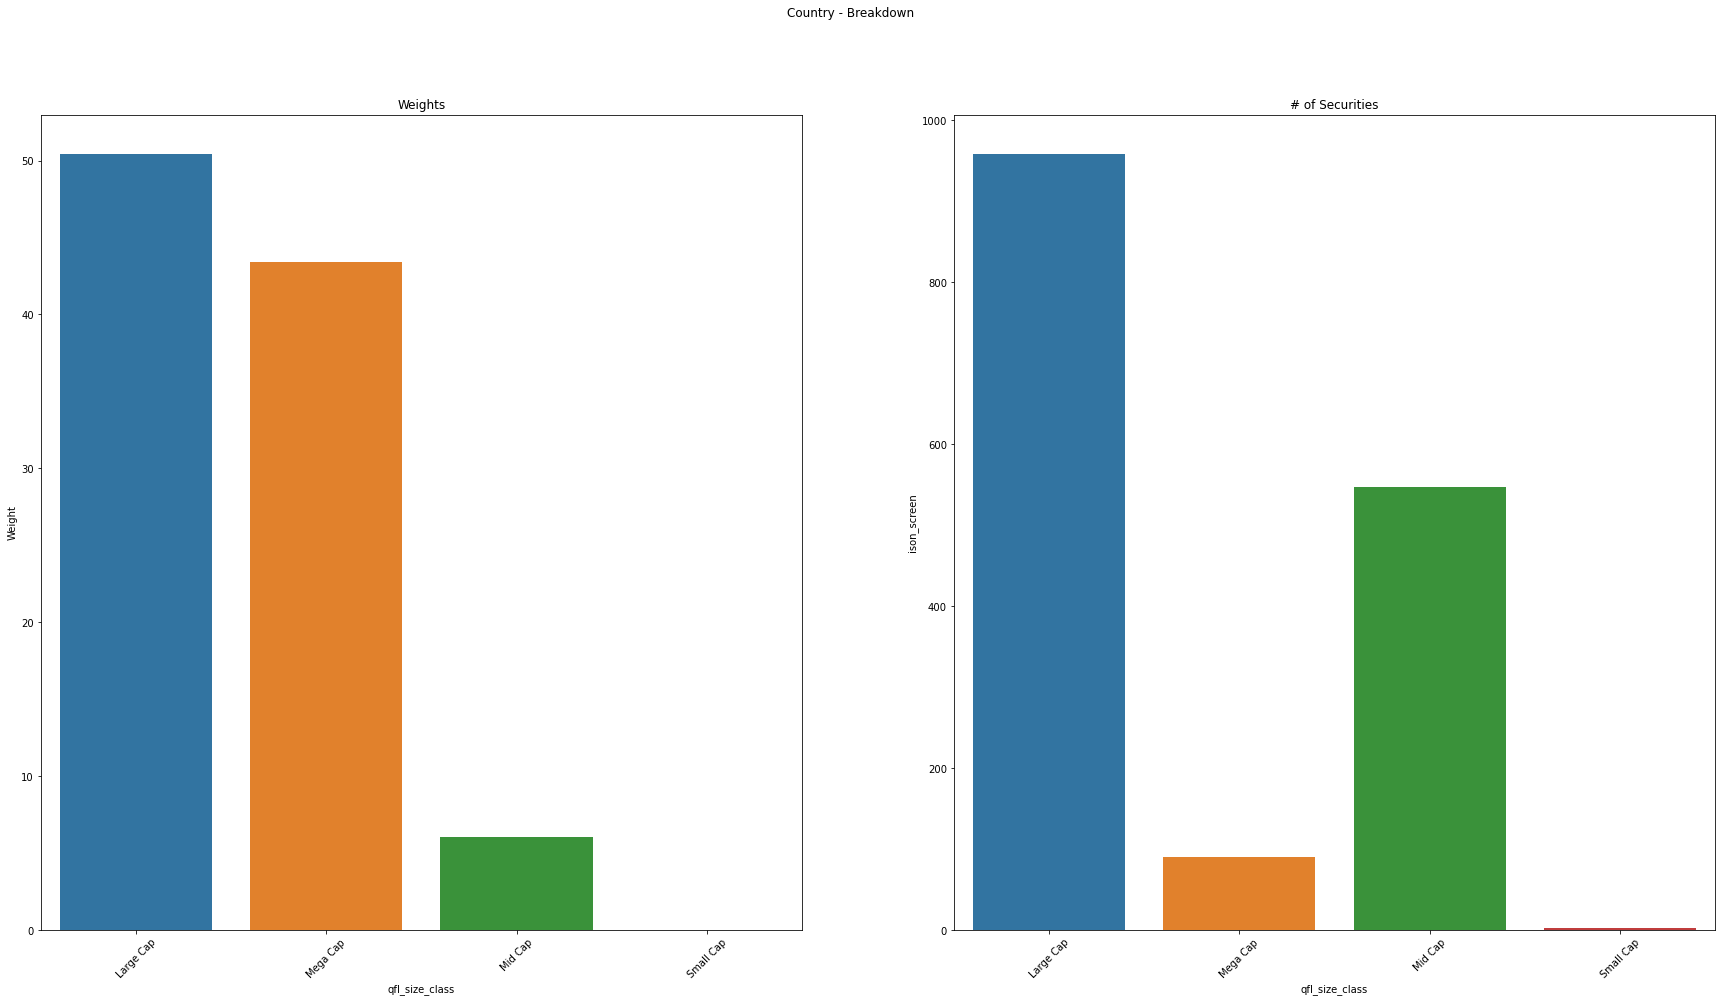

In [42]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [43]:
# Feature Selection

In [44]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [45]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-45-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [46]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False  True False False False  True False False False False
 False  True False False False False False False False False False False
 False False False False]
Feature Ranking: [18 19  5  1 20 21 22  1 23  3 24  4 25  1 26  2 11 14 15 16 12 13  9 10
  6  7  8 17]


In [47]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_INSIDER_PCTOUT(0)', 'QFL_INSIDER_NUM_BUYS(0,12M)',
       'QFL_INSIDER_NUM_OPTIONS(0,3M)'],
      dtype='object')

In [48]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,3M)"
QFL_INSIDER_PCTOUT(0),1.000000,-0.080504,-0.207859
"QFL_INSIDER_NUM_BUYS(0,12M)",-0.080504,1.000000,-0.029031
"QFL_INSIDER_NUM_OPTIONS(0,3M)",-0.207859,-0.029031,1.000000


In [49]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,3M)"
0,0.10,0.0,12.0
1,1.48,0.0,9.0
2,14.64,98.0,10.0
3,1.07,0.0,42.0
4,12.23,0.0,6.0
...,...,...,...
1595,10.55,163.0,0.0
1596,53.70,0.0,0.0
1597,1.93,35.0,0.0
1598,56.85,0.0,0.0


In [50]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,QFL_INSIDER_PCTOUT(0),"QFL_INSIDER_NUM_BUYS(0,12M)","QFL_INSIDER_NUM_OPTIONS(0,3M)",MFR
0,-0.816930,-0.311186,0.950250,-0.059289
1,-0.751820,-0.311186,0.616166,-0.148947
2,-0.130909,3.455969,0.727527,1.350862
3,-0.771164,-0.311186,4.291088,1.069579
4,-0.244617,-0.311186,0.282082,-0.091240


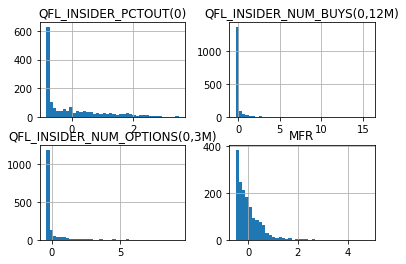

In [51]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [52]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.04
Information Coefficient (P-Value): 0.1


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [53]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.04
Information Coefficient (P-Value): 0.1


### Z-Score + Log-Transformation (All Components)

In [54]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.01
Information Coefficient (P-Value): 0.68


### Z-Score Only (All Components)

In [55]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.06
Information Coefficient (P-Value): 0.02
